<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Overview</a></span></li><li><span><a href="#Genomics-pipeline" data-toc-modified-id="Genomics-pipeline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Genomics pipeline</a></span><ul class="toc-item"><li><span><a href="#Calling-SNP-based-resistance-alleles" data-toc-modified-id="Calling-SNP-based-resistance-alleles-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Calling SNP-based resistance alleles</a></span></li><li><span><a href="#fastBAPS-clustering-of-mosaic-alleles" data-toc-modified-id="fastBAPS-clustering-of-mosaic-alleles-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>fastBAPS clustering of mosaic alleles</a></span><ul class="toc-item"><li><span><a href="#mosaic-mtrRCDE" data-toc-modified-id="mosaic-mtrRCDE-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>mosaic mtrRCDE</a></span></li><li><span><a href="#mosaic-penA" data-toc-modified-id="mosaic-penA-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>mosaic penA</a></span></li></ul></li></ul></li><li><span><a href="#Dataset-overview-and-phenotype-filtering" data-toc-modified-id="Dataset-overview-and-phenotype-filtering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dataset overview and phenotype filtering</a></span><ul class="toc-item"><li><span><a href="#Overview-of-metadata" data-toc-modified-id="Overview-of-metadata-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Overview of metadata</a></span></li><li><span><a href="#Timespan" data-toc-modified-id="Timespan-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Timespan</a></span></li><li><span><a href="#Geographical-range" data-toc-modified-id="Geographical-range-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Geographical range</a></span></li><li><span><a href="#Phenotype-processing" data-toc-modified-id="Phenotype-processing-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Phenotype processing</a></span></li></ul></li><li><span><a href="#Linear-modeling-(Supplementary-Table-2)" data-toc-modified-id="Linear-modeling-(Supplementary-Table-2)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Linear modeling (Supplementary Table 2)</a></span><ul class="toc-item"><li><span><a href="#Azithromycin" data-toc-modified-id="Azithromycin-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Azithromycin</a></span></li><li><span><a href="#Ceftriaxone" data-toc-modified-id="Ceftriaxone-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Ceftriaxone</a></span></li><li><span><a href="#Ciprofloxacin" data-toc-modified-id="Ciprofloxacin-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Ciprofloxacin</a></span></li></ul></li><li><span><a href="#GWAS" data-toc-modified-id="GWAS-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>GWAS</a></span><ul class="toc-item"><li><span><a href="#Azithromycin-GWAS-(Supplementary-Table-3)" data-toc-modified-id="Azithromycin-GWAS-(Supplementary-Table-3)-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Azithromycin GWAS (Supplementary Table 3)</a></span></li><li><span><a href="#Ceftriaxone-GWAS-(Supplementary-Table-3)" data-toc-modified-id="Ceftriaxone-GWAS-(Supplementary-Table-3)-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Ceftriaxone GWAS (Supplementary Table 3)</a></span></li><li><span><a href="#Ciprofloxacin-GWAS-(Supplementary-Table-3)" data-toc-modified-id="Ciprofloxacin-GWAS-(Supplementary-Table-3)-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Ciprofloxacin GWAS (Supplementary Table 3)</a></span></li><li><span><a href="#Q-Q-plot-(Supplementary-Figure-1)" data-toc-modified-id="Q-Q-plot-(Supplementary-Figure-1)-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Q-Q plot (Supplementary Figure 1)</a></span></li><li><span><a href="#Combined-Manhattan-plot-(Figure-2)" data-toc-modified-id="Combined-Manhattan-plot-(Figure-2)-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Combined Manhattan plot (Figure 2)</a></span></li></ul></li><li><span><a href="#Efflux-pump-LOF-&amp;-association-with-metadata" data-toc-modified-id="Efflux-pump-LOF-&amp;-association-with-metadata-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Efflux pump LOF &amp; association with metadata</a></span><ul class="toc-item"><li><span><a href="#Identifying-LOF-alleles-(Supplementary-Table-4)" data-toc-modified-id="Identifying-LOF-alleles-(Supplementary-Table-4)-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Identifying LOF alleles (Supplementary Table 4)</a></span></li><li><span><a href="#Association-with-site-of-infection-(Figure-3)" data-toc-modified-id="Association-with-site-of-infection-(Figure-3)-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Association with site of infection (Figure 3)</a></span><ul class="toc-item"><li><span><a href="#Aggregating-across-efflux-pump-mutations" data-toc-modified-id="Aggregating-across-efflux-pump-mutations-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Aggregating across efflux pump mutations</a></span></li></ul></li><li><span><a href="#Association-with-sexual-orientation-(Figure-3)" data-toc-modified-id="Association-with-sexual-orientation-(Figure-3)-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Association with sexual orientation (Figure 3)</a></span></li></ul></li><li><span><a href="#N.-meningitidis-analysis-(Figure-4)" data-toc-modified-id="N.-meningitidis-analysis-(Figure-4)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>N. meningitidis analysis (Figure 4)</a></span><ul class="toc-item"><li><span><a href="#Dataset-and-Phylogenetics" data-toc-modified-id="Dataset-and-Phylogenetics-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Dataset and Phylogenetics</a></span></li><li><span><a href="#LOF-calling" data-toc-modified-id="LOF-calling-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>LOF calling</a></span></li><li><span><a href="#Overrepresentation-in-urogenital-clade" data-toc-modified-id="Overrepresentation-in-urogenital-clade-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Overrepresentation in urogenital clade</a></span></li></ul></li></ul></div>

## Overview
We've included analysis code used to replicate the results and all figures for Ma and Mortimer et al., 2020 ("Increased antibiotic susceptibility in Neisseria gonorrhoeae through adaptation to the cervical environment"). Please reach out with any questions to kevinchenma@g.harvard.edu and mortimer@hsph.harvard.edu and we'll be happy to assist.

## Genomics pipeline

First, we give a brief schematic overview of the genomics pipeline. Since these are primarily based off existing tools, we won't go step by step through them but would be happy to share additional code on request. The full list of parameters are available in the methods in the paper. The end result of the pipeline will be mapping-based pseudogenomes and de novo assemblies for each isolate, and a recombination-corrected phylogeny generated via Gubbins.

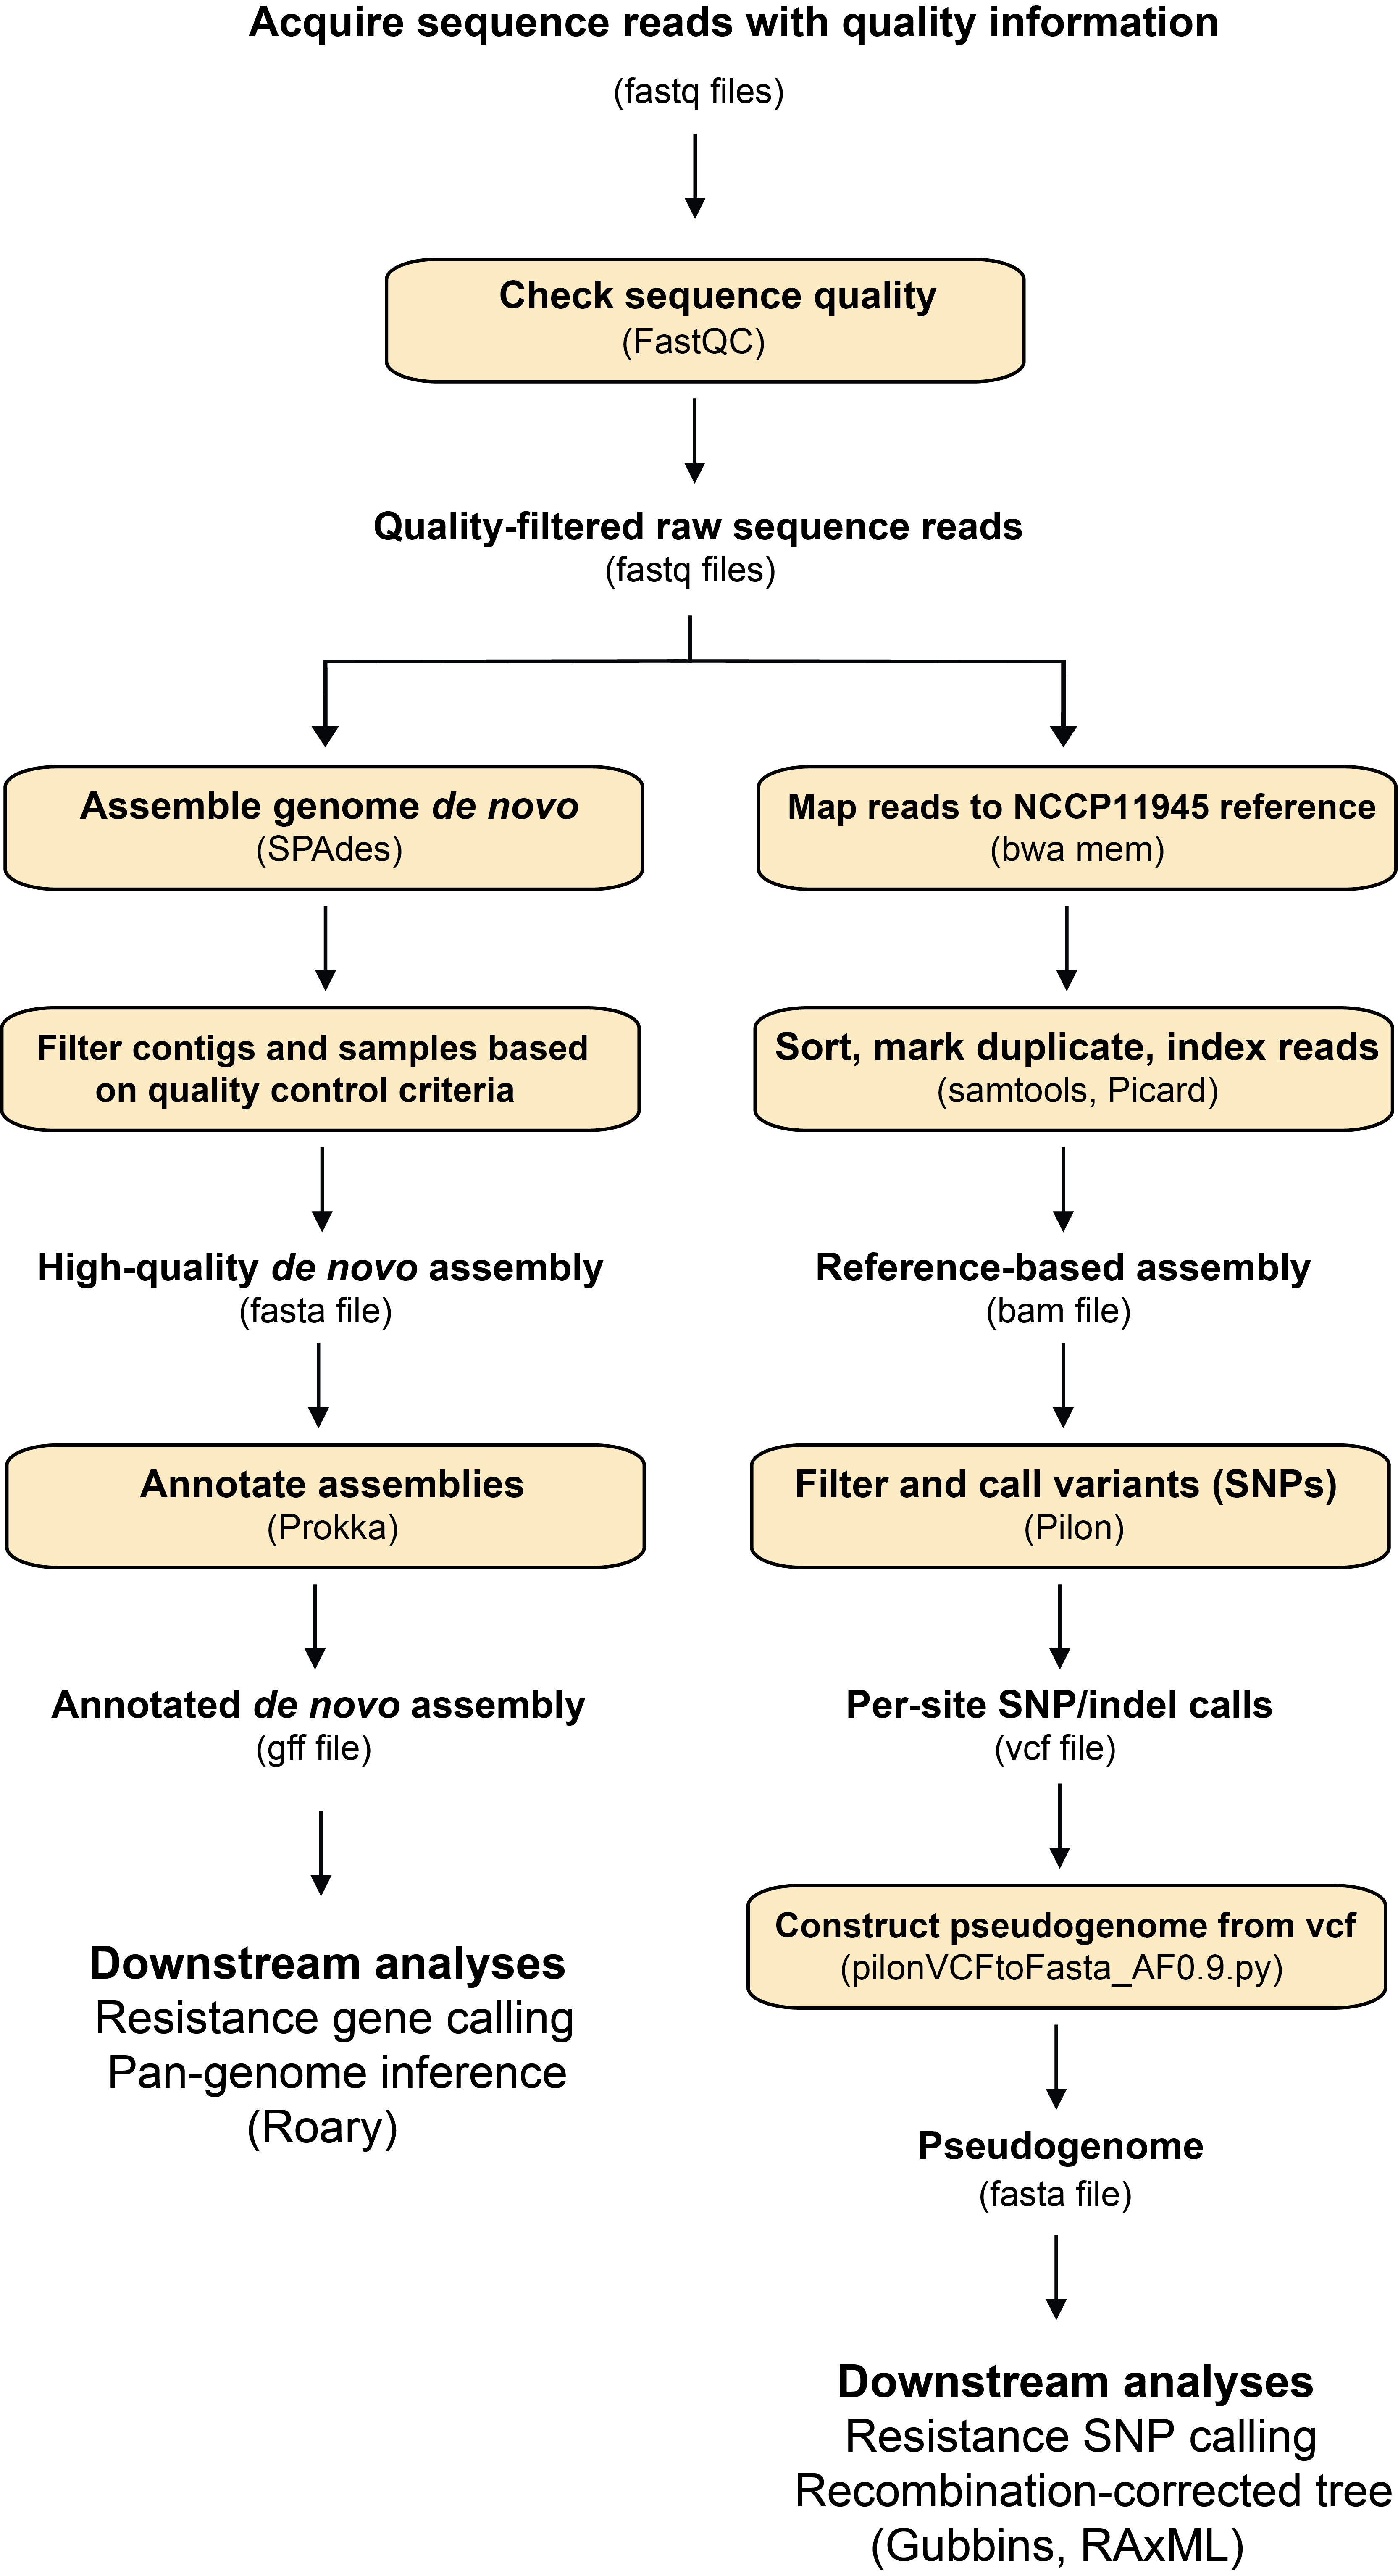

In [1]:
from IPython.display import Image
Image(filename='software/Ng-pipeline.png') 

### Calling SNP-based resistance alleles

We use a custom script to call SNP-based resistance (available in scripts/resistance_alleles_pseudogenomes.py) which takes the aligned pseudogenomes as input and checks nucleotide identity at positions corresponding to known resistance SNPs. The results, along with the results of the fastBAPS clustering below, are summarized in linear-models/covariates/combined-covariates.csv.

### fastBAPS clustering of mosaic alleles

We used fastBAPS to cluster nucleotide sequences of penA and the mtrRCDE operon for usage as a covariate in the linear regression MIC prediction models. This provided a flexible, categorical representation of the mosaic alleles without needing to explicitly map to and identify known alleles. Because this is a bit different than other resistance allele calling approaches, we've included all of the necessary code below.

**Dependencies: We used BLASTn (version 2.6.0) to pull out genes of interest from the assemblies. We set up a BLASTn database using all of the contigs in our dataset; we did not upload this to Github due to size constraints but would be happy to provide it directly upon request. We also installed fastBAPS (version 1.0.0) and its dependencies, and MAFFT (version 7.450). We used rpy2 to run the R code directly within the notebook, but this is optional.**

#### mosaic mtrRCDE

First, we pulled out the whole mtrR through mtrCDE nucleotide sequence using a query sequence from reference strain FA1090 and the BLASTn database of the contigs, and converted the results to a FASTA file after some minor quality control for length.

In [34]:
!blastn -db blast/2019-08-26_combined-contigs.fna -query linear-models/covariates/FA1090-mtrprom-mtrCDE.fna -num_descriptions 10000 -num_alignments 10000 -out linear-models/covariates/mtr-combined.txt
!blastn -db blast/2019-08-26_combined-contigs.fna -query linear-models/covariates/FA1090-mtrprom-mtrCDE.fna -outfmt '6 sseqid length evalue sseq' -max_target_seqs 10000 -out linear-models/covariates/mtr-combined.tsv

In [35]:
samples = []
with open('linear-models/covariates/mtr-combined.fna', 'w') as outfile, open('linear-models/covariates/mtr-combined.tsv', 'r') as infile:
    for line in infile:
        name,length,evalue,fasta = line.rstrip().split('\t')
        if int(length) < 4000:
            continue
        else:
            outfile.write('>' + name.split('|')[0] + '\n')
            outfile.write(fasta + '\n')
            if name in samples:
                print('Duplicate ' + name)
            else:
                samples.append(name)

We aligned the FASTA file using MAFFT and passed it to fastBAPS for clustering using R. This will give a table of samples and the corresponding fastBAPS cluster for the mtrRCDE operon.

In [42]:
!software/mafft-linux64/mafft.bat linear-models/covariates/mtr-combined.fna > linear-models/covariates/mtr-combined-aligned.fna

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
 4901 / 4941
done.

Constructing a UPGMA tree (efffree=0) ... 
 4930 / 4941
done.

Progressive alignment 1/2... 
STEP  4801 / 4940  h
Reallocating..done. *alloclen = 10553
STEP  4901 / 4940 
done.

Making a distance matrix from msa.. 
 4900 / 4941
done.

Constructing a UPGMA tree (efffree=1) ... 
 4930 / 4941
done.

Progressive alignment 2/2... 
STEP  4901 / 4940  h
Reallocating..done. *alloclen = 10552

done.

disttbfast (nuc) Version 7.450
alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring schem

In [43]:
%load_ext rpy2.ipython

In [48]:
%%R -w 8 -h 4 --units in -r 400

library(fastbaps)
library(ape)

sparse.data <- import_fasta_sparse_nt("linear-models/covariates/mtr-combined-aligned.fna")
sparse.data <- optimise_prior(sparse.data, type = "optimise.symmetric")

baps.hc <- fast_baps(sparse.data)

clusters <- best_baps_partition(sparse.data, as.phylo(baps.hc))

write.table(clusters, file = "linear-models/covariates/mtr-combined-fastBAPS.csv", row.names = TRUE, sep = ',', quote = FALSE, col.names = FALSE)

[1] "Optimised hyperparameter: 0.009"
[1] "Calculating initial clustering..."
[1] "Calculating initial dk values..."
[1] "Clustering using hierarchical Bayesian clustering..."
[1] "Calculating node marginal llks..."
[1] "Finding best partition..."


In [50]:
!head linear-models/covariates/mtr-combined-fastBAPS.csv

FA1090,10
SRR3360687,10
ERR388284,10
ERR388345,10
ERR349956,10
ERR388402,10
ERR349937,10
ERR388321,10
ERR349942,10
SRR3361345,10


#### mosaic penA

We used the same pipeline for identifying mosaic penA clusters.

In [51]:
!blastn -db blast/2019-08-26_combined-contigs.fna -query linear-models/covariates/FA1090-penA.fna -num_descriptions 10000 -num_alignments 10000 -out linear-models/covariates/penA-combined.txt
!blastn -db blast/2019-08-26_combined-contigs.fna -query linear-models/covariates/FA1090-penA.fna -outfmt '6 sseqid length evalue sseq' -max_target_seqs 10000 -out linear-models/covariates/penA-combined.tsv

In [53]:
samples = []
with open('linear-models/covariates/penA-combined.fna', 'w') as outfile, open('linear-models/covariates/penA-combined.tsv', 'r') as infile:
    for line in infile:
        name,length,evalue,fasta = line.rstrip().split('\t')
        if int(length) < 1500:
            continue
        else:
            outfile.write('>' + name.split('|')[0] + '\n')
            outfile.write(fasta + '\n')            
            if name in samples:
                print('Duplicate ' + name)
            else:
                samples.append(name)

In [55]:
!software/mafft-linux64/mafft.bat linear-models/covariates/penA-combined.fna > linear-models/covariates/penA-combined-aligned.fna

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
 4901 / 4914
done.

Constructing a UPGMA tree (efffree=0) ... 
 4910 / 4914
done.

Progressive alignment 1/2... 
STEP  4901 / 4913  h
done.

Making a distance matrix from msa.. 
 4900 / 4914
done.

Constructing a UPGMA tree (efffree=1) ... 
 4910 / 4914
done.

Progressive alignment 2/2... 
STEP  4901 / 4913 
done.

disttbfast (nuc) Version 7.450
alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions

In [70]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [56]:
%%R -w 8 -h 4 --units in -r 400

library(fastbaps)
library(ape)

sparse.data <- import_fasta_sparse_nt("linear-models/covariates/penA-combined-aligned.fna")
sparse.data <- optimise_prior(sparse.data, type = "optimise.symmetric")

baps.hc <- fast_baps(sparse.data)

clusters <- best_baps_partition(sparse.data, as.phylo(baps.hc))

write.table(clusters, file = "linear-models/covariates/penA-combined-fastBAPS.csv", row.names = TRUE, sep = ',', quote = FALSE, col.names = FALSE)

[1] "Optimised hyperparameter: 0.003"
[1] "Calculating initial clustering..."
[1] "Calculating initial dk values..."
[1] "Clustering using hierarchical Bayesian clustering..."
[1] "Calculating node marginal llks..."
[1] "Finding best partition..."


In [57]:
!head linear-models/covariates/penA-combined-fastBAPS.csv

FA1090,14
ERR388323,14
ERR363579,14
ERR449525,14
ERR349961,14
ERR349925,14
ERR388339,14
ERR388346,14
ERR388446,14
ERR449514,14


## Dataset overview and phenotype filtering

### Overview of metadata

**Dependencies: we use the following Python packages extensively for data analyses throughout the notebook.**

In [1]:
import numpy as np
import statsmodels
import statsmodels.formula.api as smf
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from Bio import SeqIO
from collections import Counter
%matplotlib inline

We read in the metadata file for the global dataset; there should be 4852 samples included.

In [2]:
metadata = pd.read_csv('metadata/2020-04-27_Supplementary-Table-6_Global-Strain-Collection.csv')
metadata.shape

(4852, 16)

### Timespan
A summary of the timespan of collection and number of strains per dataset:

In [15]:
metadata['Year_only'] = metadata['Year'].apply(lambda x: float(str(x).split('-')[0]))

for dataset in Counter(metadata['Reference']):
    years = sorted(metadata[metadata['Reference'] == dataset].Year_only)
    print(min(years), max(years), dataset, len(years))

1989.0 2013.0 Demczuk2015 114
1991.0 2014.0 Demczuk2016 199
2004.0 2011.0 Eyre2017 231
1982.0 2011.0 Ezewudo2015 54
2004.0 2017.0 Fifer2018 50
2000.0 2013.0 Grad2014_2016 1100
2013.0 2013.0 Harris2018 1048
2006.0 2014.0 Kwong2017 94
2014.0 2015.0 Lee2018 397
2011.0 2015.0 MortimerUnpub 888
2012.0 2016.0 Ryan2018 39
1979.0 2012.0 SanchezBuso2018 378
1996.0 2015.0 Yahara2018 260


Number of isolates collected by year:

/home/kcm14/anaconda3/envs/pyseer/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/kcm14/anaconda3/envs/pyseer/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


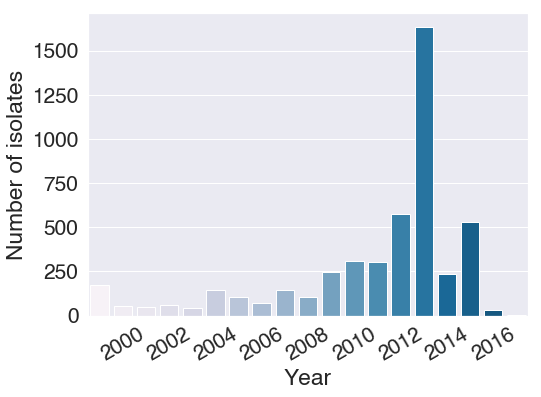

In [16]:
sns.set(font_scale = 1.9)

plotmetadata = metadata[pd.notnull(metadata['Year_only'])]
plotmetadata['Year_only'] = plotmetadata['Year_only'].apply(lambda x: (int(float(str(x).split('-')[0]))))
plotmetadata['Year_only'] = plotmetadata['Year_only'].apply(lambda x: str(x) if x >= 2000 else '1979-1999')

fig, ax = plt.subplots(figsize=(8,6))
sns.set_style({'font.sans-serif': 'helvetica'})

sns.countplot(sorted(plotmetadata['Year_only']), ax=ax, palette=sns.color_palette("PuBu", 20))

plt.xticks(rotation=30)
plt.ylabel('Number of isolates')
plt.xlabel('Year')
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

sns.set_style({'font.sans-serif': 'helvetica'})
plt.tight_layout()

### Geographical range

Number of isolates collected by continent for the most frequent continents:

/home/kcm14/anaconda3/envs/pyseer/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


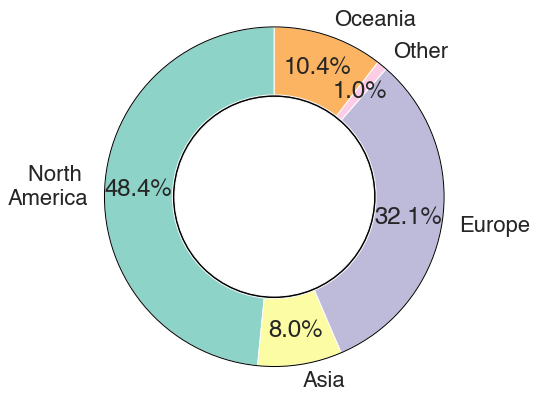

In [69]:
sns.set(font_scale = 2)
sns.set_style({'font.sans-serif': 'helvetica'})

plotmetadata2 = metadata[pd.notnull(metadata['Continent'])]
plotmetadata2['Continent2'] = plotmetadata2['Continent'].apply(lambda x: x if x in ['North America', 'Asia', 'Europe', 'Oceania'] else 'Other')

fig, ax = plt.subplots(figsize=(8,6))

centre_circle3 = plt.Circle((0,0),1.0,ec='black', fill=False)
fig.gca().add_artist(centre_circle3)

labels = ['North \nAmerica', 'Asia', 'Europe', 'Other', 'Oceania']
sizes = list(Counter(plotmetadata2['Continent2']).values())
colors = ['#8dd3c7','#fcfca4','#bebada','#fccde5', '#fdb462']
explode = (0,0,0,0)
 
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.80)
centre_circle = plt.Circle((0,0),0.585,fc='white')
centre_circle2 = plt.Circle((0,0),0.60,fc='black')
fig.gca().add_artist(centre_circle2)
fig.gca().add_artist(centre_circle)

plt.axis('equal')  
plt.tight_layout()

Number of countries included:

In [23]:
len(Counter(metadata['Country']))

65

### Phenotype processing

We took a few filtering steps to clean up and standardize the MICs. Some isolates only had binary 'RES' or 'SUS' information; we removed those samples. Some isolates only had relative MIC values (e.g., >=8); we set those to be equal to the provided threshold (i.e., 8). We also log2-transformed MICs for both linear modeling and GWAS. Finally, for azithromycin, we multiplied MICs of CDC GISP isolates prior to 2005 by two as previously done (Grad et al., 2016) to account for a known change in the MIC measurement media protocol. **We will use these corrected metadata files for the rest of the analysis.**

In [1]:
import pandas as pd
import numpy as np

metadata_filtered = pd.read_csv('metadata/2020-04-27_Supplementary-Table-6_Global-Strain-Collection.csv')
metadata_filtered = metadata_filtered.replace('SUS', np.nan)
metadata_filtered = metadata_filtered.replace('RES', np.nan)

metadata_filtered['AZI_LOG'] = metadata_filtered['Azithromycin'].map(lambda x: float(str(x).lstrip('><=')))

adjusted_MIC = []
for index, row in metadata_filtered.iterrows():
    if not row['Reference'].startswith('Grad'):
        adjusted_MIC.append(row['AZI_LOG'])
    else:
        if int(row['Year']) < 2005:
            adjusted_MIC.append(2*row['AZI_LOG'])
        else:
            adjusted_MIC.append(row['AZI_LOG'])
            
metadata_filtered['Azithromycin'] = adjusted_MIC
metadata_filtered['AZI_LOG'] = np.log2(metadata_filtered['Azithromycin'])

metadata_filtered['CRO_LOG'] = np.log2(metadata_filtered['Ceftriaxone'].map(lambda x: float(str(x).lstrip('><='))))
metadata_filtered['CIP_LOG'] = np.log2(metadata_filtered['Ciprofloxacin'].map(lambda x: float(str(x).lstrip('><='))))

metadata_filtered.to_csv('metadata/strain-table-filtered.csv', index=False)
metadata_filtered.to_csv('metadata/gwas-strain-table-filtered.tsv', sep='\t', index=False, columns=['GWAS_ID', 'Country', 'Reference', 'AZI_LOG', 'CRO_LOG', 'CIP_LOG'])

We are left with the following number of samples for each drug for linear modeling / GWAS.

In [2]:
metadata_filtered.count()[-3:]

AZI_LOG    4505
CRO_LOG    4497
CIP_LOG    4135
dtype: int64

## Linear modeling (Supplementary Table 2)

We first used a regression model based on the known resistance determinants to assess how much resistance / susceptibility was already explained, in order to motivate usage of GWAS. To do this we make use of the previously called resistance alleles. We've summarized those for our dataset in the linear-models/covariates/combined-covariates.csv file.

**Dependencies: We conducted the statistical analyses in R (version 3.5.1), making use of the tidyverse, dplyr, and ggplot2 libraries. We used rpy2 to run the R code directly within the notebook, but this is optional.**

In [3]:
import numpy as np
import statsmodels
import statsmodels.formula.api as smf
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from Bio import SeqIO
from collections import Counter
%matplotlib inline

### Azithromycin

We read in the covariates and the MIC file and subset to strains with azithromycin MICs (n=4505). After setting baseline levels for the factors to facilitate interpretation, we run regression comparing the model fits with and without inclusion of mtrC LOF alleles.

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R -o azi_df -w 8 -h 4 --units in -r 400

library(tidyverse)
library(dplyr)
library(ggplot2)

azi_df = read.table("linear-models/covariates/combined-covariates.csv", sep=",", header=TRUE, comment.char="", na.strings=c("", "NA"), stringsAsFactors=FALSE)
pheno = read.table("metadata/strain-table-filtered.csv", sep=",", header=TRUE, comment.char="", na.strings=c("", "NA"), stringsAsFactors=FALSE)
pheno <- pheno %>%
    select(GWAS_ID, AZI_LOG, CRO_LOG, CIP_LOG, MtrC)

azi_df <- azi_df %>% 
    left_join(pheno, by = c("GWAS_ID")) %>% 
    select(GWAS_ID, Country, AZI_LOG, MtrR_39, MtrR_45, RplD_70, mtr_promoter, 
           mtrR, Mosaic_Mtr_BAPS, rRNA23S_2059, rRNA23S_2611, MtrC) %>%
    filter(!is.na(AZI_LOG)) %>%

   replace(is.na(.), "Unmapped") %>% # Some mosaic alleles do not map well in SNP calling

    within(., Country <- relevel(factor(Country), ref = "USA")) %>% # Relevel baseline factors to faciliate interpretation
    within(., MtrR_39 <- relevel(factor(MtrR_39), ref = "A")) %>%
    within(., MtrR_45 <- relevel(factor(MtrR_45), ref = "G")) %>% 
    within(., RplD_70 <- relevel(factor(RplD_70), ref = "G")) %>% 
    within(., mtr_promoter <- relevel(factor(mtr_promoter), ref = "A")) %>%
    within(., mtrR <- relevel(factor(mtrR), ref = "full_length")) %>%
    within(., Mosaic_Mtr_BAPS <- relevel(factor(Mosaic_Mtr_BAPS), ref = "11")) %>%
    within(., MtrC <- relevel(factor(MtrC), ref = "Intact"))

print(dim(azi_df))
head(azi_df, n=10)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] 4505   12
      GWAS_ID Country   AZI_LOG MtrR_39 MtrR_45 RplD_70 mtr_promoter
1  SRR1661153  Canada -1.000000       A       D       G            -
2  SRR1661154  Canada -2.000000       T       G       G            -
3  SRR1661155  Canada  0.000000       A       G       G            -
4  SRR1661156  Canada -2.000000       T       D       G            -
5  SRR1661157  Canada -3.000000       A       G       G     Unmapped
6  SRR1661158  Canada -2.000000       A       D       G            -
7  SRR1661159  Canada -3.988504       A       G       G            A
8  SRR1661161  Canada -1.000000       A       G       G            -
9  SRR1661162  Canada -3.988504       A       G       G            A
10 SRR1661163  Canada -1.000000       T       G       G            A
          mtrR Mosaic_Mtr_BAPS rRNA23S_2059 rRNA23S_2611   MtrC
1  full_length              11            0            0 Intact
2  full_length              11            0            0 Intact
3  full_length              11     

Now we run the regression on the genetic determinants for azithromycin resistance, comparing the results with and without including mtrC LOF alleles.

In [6]:
%%R -w 8 -h 4 --units in -r 400

library(jtools)
options(width = 250) 

model1 <- lm(AZI_LOG ~ (.-GWAS_ID-MtrC), data=azi_df, x=TRUE, y=TRUE)
write.csv(tidy(model1) %>% select('term', 'std.error', 'estimate', 'p.value'), 'linear-models/results/lm-AZI.csv', row.names = FALSE)
summary(model1)

model2 <- lm(AZI_LOG ~ (.-GWAS_ID), data=azi_df, x=TRUE, y=TRUE)
write.csv(tidy(model2) %>% select('term', 'std.error', 'estimate', 'p.value'), 'linear-models/results/lm-AZI-mtrC.csv', row.names = FALSE)
summary(model2)


Call:
lm(formula = AZI_LOG ~ Country + (. - GWAS_ID - Country), data = azi_df, 
    x = TRUE, y = TRUE)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.2256  -0.6577   0.0690   0.6550   8.3291 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                -2.59723    0.06078 -42.732  < 2e-16 ***
CountryAngola              -0.71920    1.21676  -0.591 0.554499    
CountryArgentina            0.34228    1.21650   0.281 0.778443    
CountryArmenia              0.67311    1.21737   0.553 0.580343    
CountryAustralia           -0.69973    0.12106  -5.780 7.97e-09 ***
CountryAustria             -0.03016    0.54452  -0.055 0.955831    
CountryBelarus              0.12162    0.24540   0.496 0.620217    
CountryBelgium             -0.10830    0.16785  -0.645 0.518804    
CountryBhutan              -1.43434    0.57508  -2.494 0.012663 *  
CountryBrazil              -0.18021    0.86156  -0.209 0.834327    
CountryBulgaria            -

As a regression diagnostic, we check that the residuals are approximately normally distributed. We saw above in the regression output that the individual coefficient for MtrC LOF was significant, but we also formally test whether inclusion of MtrC LOF improves overall model fit using a Chi-squared test for nested models and see that this result is significant as well.

Analysis of Variance Table

Model 1: AZI_LOG ~ Country + ((GWAS_ID + Country + MtrR_39 + MtrR_45 + 
    RplD_70 + mtr_promoter + mtrR + Mosaic_Mtr_BAPS + rRNA23S_2059 + 
    rRNA23S_2611 + MtrC) - GWAS_ID - Country - MtrC)
Model 2: AZI_LOG ~ Country + ((GWAS_ID + Country + MtrR_39 + MtrR_45 + 
    RplD_70 + mtr_promoter + mtrR + Mosaic_Mtr_BAPS + rRNA23S_2059 + 
    rRNA23S_2611 + MtrC) - GWAS_ID - Country)
  Res.Df    RSS Df Sum of Sq  Pr(>Chi)    
1   4412 7548.9                           
2   4411 6511.2  1    1037.8 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


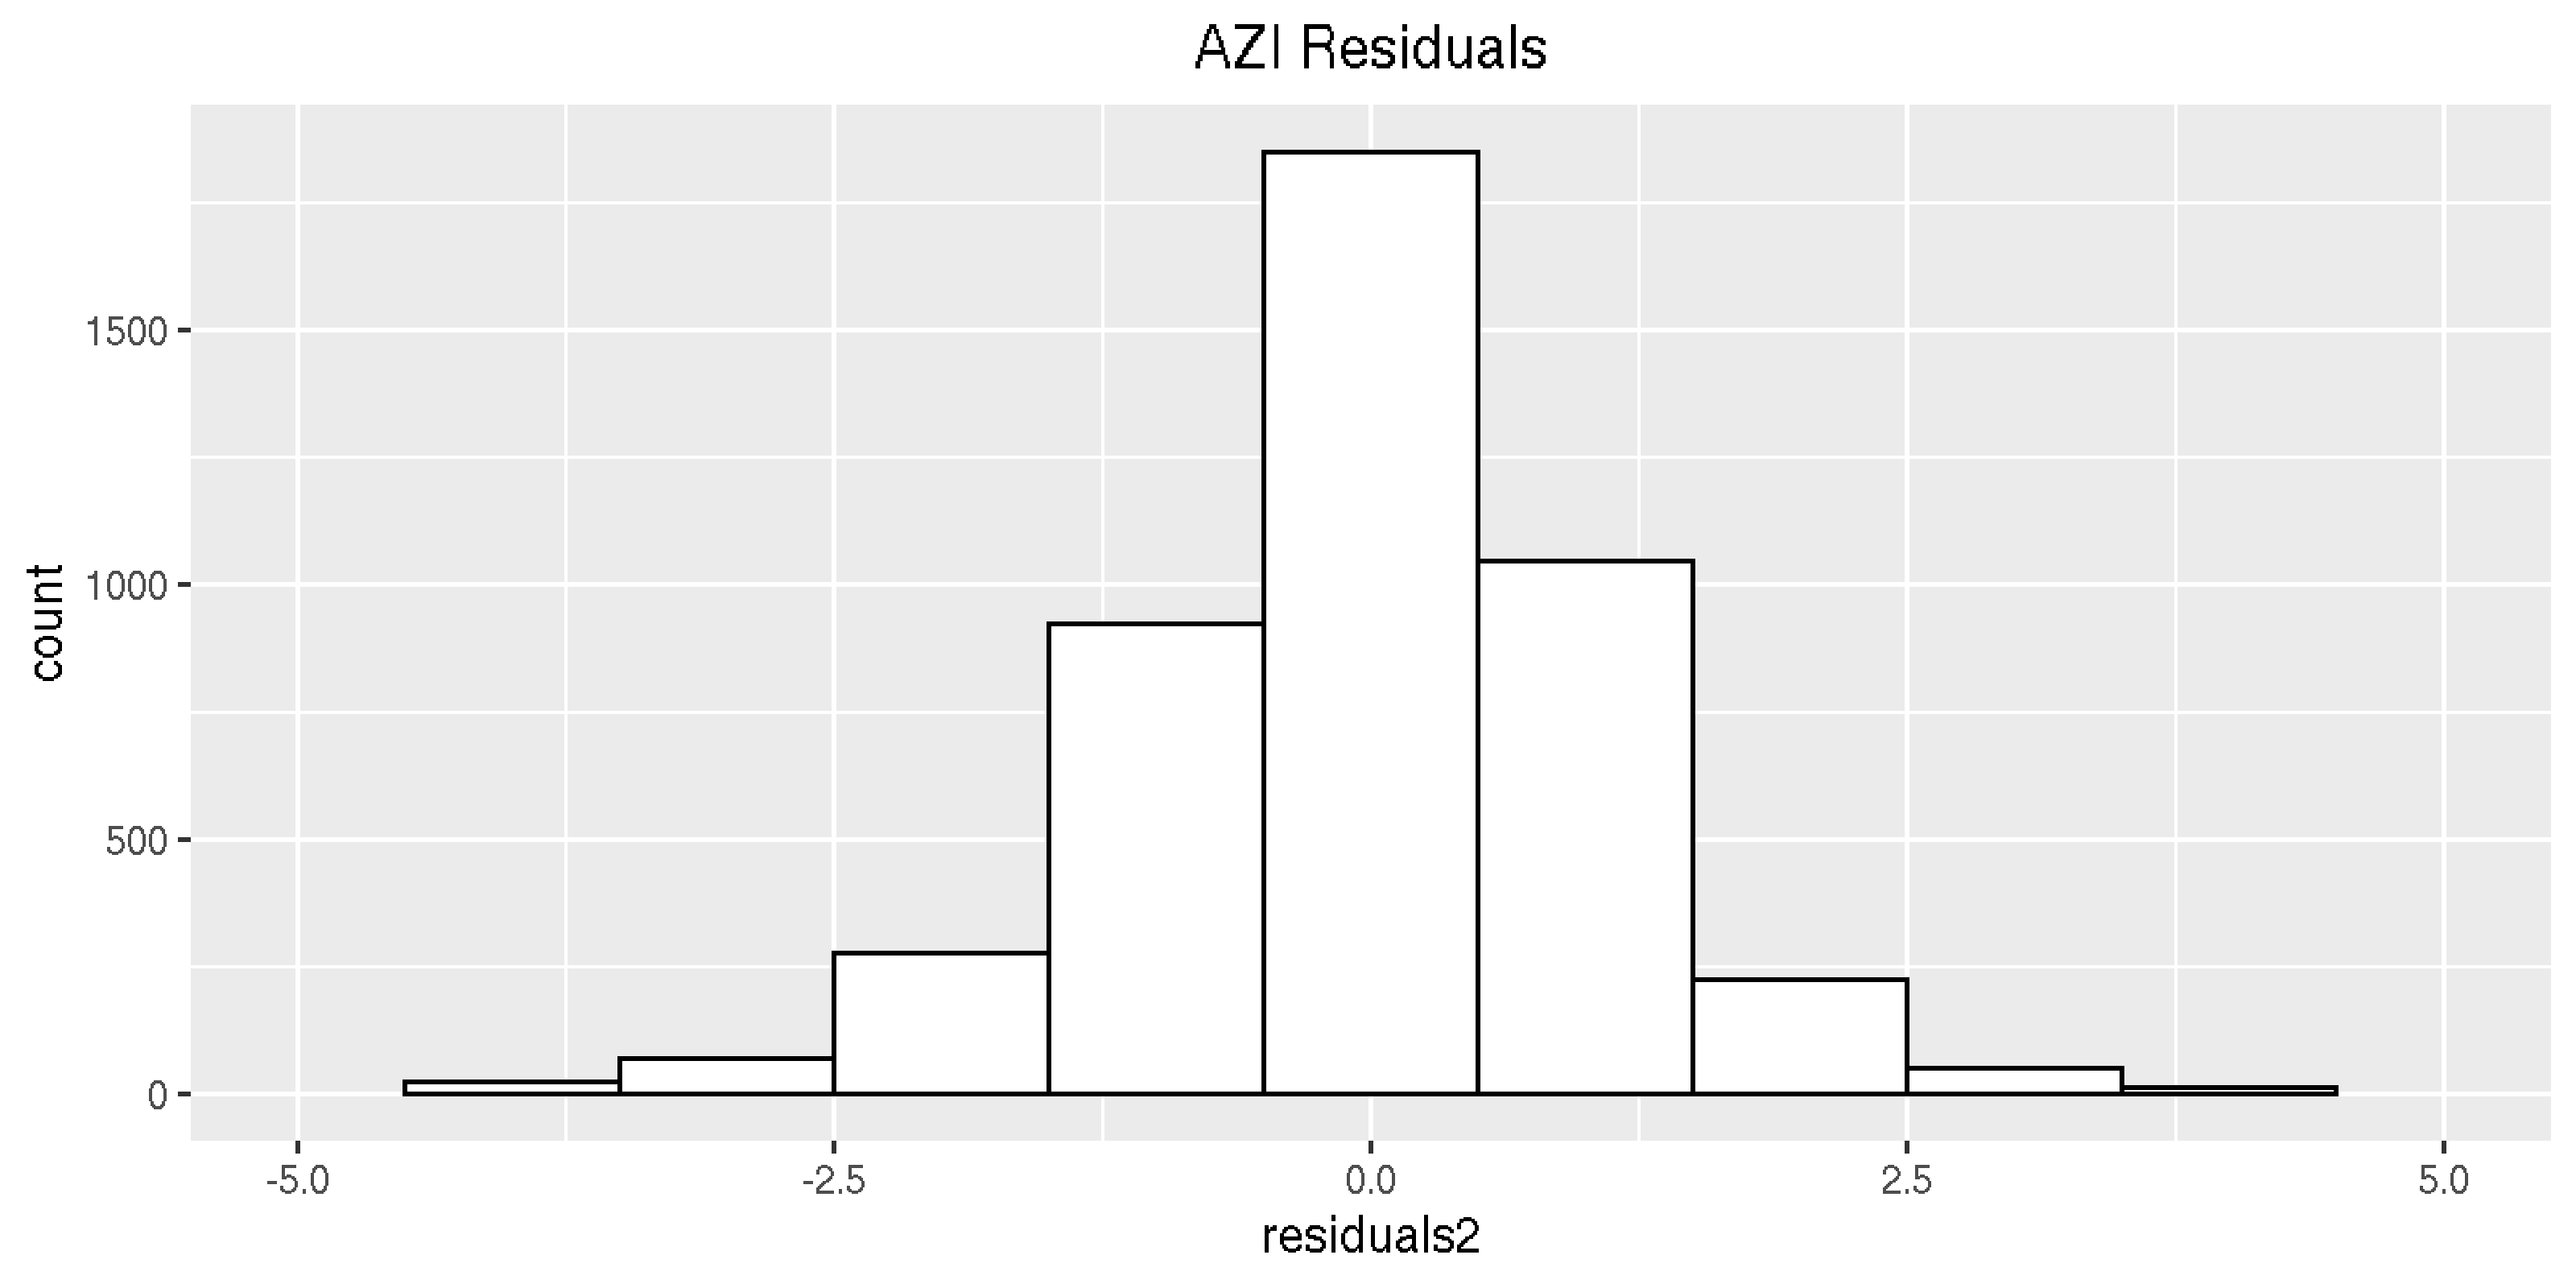

In [7]:
%%R -w 8 -o residuals1 -o residuals2 -h 4 --units in -r 400

print(anova(model1, model2, test='Chisq'))

residuals1 <- resid(model1)
residuals2 <- resid(model2)
ggplot() + aes(residuals2)+ geom_histogram(binwidth=1, colour="black", fill="white") + ggtitle("AZI Residuals") + theme(plot.title = element_text(hjust = 0.5)) + xlim(-5, 5)

Finally, we compare the changes in the number of strains with unexplained susceptibility (defined as actual MIC two dilutions or lower than predicted MIC from the model). This is equivalent to asking about the number of strains with residuals (or model error) less than or equal to -2.

In [8]:
total_n = len(residuals1)
model1_error = sum([True if abs(x) > 2 else False for x in residuals1])
model2_error = sum([True if abs(x) > 2 else False for x in residuals2])
model1_unexpsus = sum([True if x < -2 else False for x in residuals1])
model2_unexpsus = sum([True if x < -2 else False for x in residuals2])

print('''Out of {0} strains with azithromycin MICs, in the baseline model {1} strains ({2}%)
had MICs that deviated by two dilutions or more from predicted MICs. {3} strains ({4}%) had MICs
that were lower than expected, indicating unexplained susceptibility. After addition of MtrC LOFs,
{5} strains ({6}%) had MICs that deviated by two dilutions or more from predicted MICs, and the
number of strains with unexplained susceptibility decreased to {7} strains ({8}%).
'''.format(total_n, model1_error, round(model1_error/total_n*100,2), model1_unexpsus, round(model1_unexpsus/total_n*100,2),
             model2_error, round(model2_error/total_n*100,2), model2_unexpsus, round(model2_unexpsus/total_n*100,2)))

Out of 4505 strains with azithromycin MICs, in the baseline model 434 strains (9.63%)
had MICs that deviated by two dilutions or more from predicted MICs. 258 strains (5.73%) had MICs
that were lower than expected, indicating unexplained susceptibility. After addition of MtrC LOFs,
339 strains (7.52%) had MICs that deviated by two dilutions or more from predicted MICs, and the
number of strains with unexplained susceptibility decreased to 175 strains (3.88%).



### Ceftriaxone

We repeat the same pipeline we used above for azithromycin, but now for ceftriaxone and its resistance determinants.

In [30]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [9]:
%%R -o cro_df -w 8 -h 4 --units in -r 400

library(tidyverse)
library(dplyr)
library(ggplot2)

cro_df = read.table("linear-models/covariates/combined-covariates.csv", sep=",", header=TRUE, comment.char="", na.strings=c("", "NA"), stringsAsFactors=FALSE)
pheno = read.table("metadata/strain-table-filtered.csv", sep=",", header=TRUE, comment.char="", na.strings=c("", "NA"), stringsAsFactors=FALSE)
pheno <- pheno %>%
    select(GWAS_ID, AZI_LOG, CRO_LOG, CIP_LOG, MtrC)

cro_df <- cro_df %>% 
    left_join(pheno, by = c("GWAS_ID")) %>% 
    select(GWAS_ID, Country, CRO_LOG, MtrR_39, MtrR_45, mtr_promoter, 
           mtrR, Mosaic_PenA_BAPS, PBP1_421, PBP2_501, PBP2_542, PBP2_551, PorB_120, PorB_121, MtrC) %>%
    filter(!is.na(CRO_LOG)) %>%

   replace(is.na(.), "Unmapped") %>% # Some mosaic alleles do not map well in SNP calling

    within(., Country <- relevel(factor(Country), ref = "USA")) %>% # Relevel baseline factors to faciliate interpretation
    within(., MtrR_39 <- relevel(factor(MtrR_39), ref = "A")) %>%
    within(., MtrR_45 <- relevel(factor(MtrR_45), ref = "G")) %>%
    within(., PBP1_421 <- relevel(factor(PBP1_421), ref = 'L')) %>%
    within(., PBP2_501 <- relevel(factor(PBP2_501), ref = 'A')) %>%
    within(., PBP2_542 <- relevel(factor(PBP2_542), ref = 'G')) %>%
    within(., PBP2_551 <- relevel(factor(PBP2_551), ref = 'P')) %>%
    within(., PorB_120 <- relevel(factor(PorB_120), ref = 'G')) %>%
    within(., PorB_121 <- relevel(factor(PorB_121), ref = 'A')) %>%
    within(., mtr_promoter <- relevel(factor(mtr_promoter), ref = "A")) %>%
    within(., mtrR <- relevel(factor(mtrR), ref = "full_length")) %>%
    within(., Mosaic_PenA_BAPS <- relevel(factor(Mosaic_PenA_BAPS), ref = '17')) %>%
    within(., MtrC <- relevel(factor(MtrC), ref = "Intact"))

print(dim(cro_df))
head(cro_df, n=10)

[1] 4497   15
      GWAS_ID Country    CRO_LOG MtrR_39 MtrR_45 mtr_promoter        mtrR Mosaic_PenA_BAPS PBP1_421 PBP2_501 PBP2_542 PBP2_551 PorB_120 PorB_121   MtrC
1  SRR1661153  Canada  -3.000000       A       D            - full_length               17        P        A        S        P        K        D Intact
2  SRR1661154  Canada  -3.000000       T       G            - full_length               17        P        V        G        S        K        D Intact
3  SRR1661155  Canada  -2.000000       A       G            - full_length               17        P        A        G        L        K        D Intact
4  SRR1661156  Canada  -3.000000       T       D            - full_length               15        P        V        S        P        K        D Intact
5  SRR1661157  Canada  -3.000000       A       G     Unmapped full_length               17        P        A        S        P        K        D Intact
6  SRR1661158  Canada  -3.000000       A       D            - full_length 

In [10]:
%%R -w 8 -h 4 --units in -r 400

library(jtools)
options(width = 250) 

model1 <- lm(CRO_LOG ~ (.-GWAS_ID-MtrC), data=cro_df, x=TRUE, y=TRUE)
write.csv(tidy(model1) %>% select('term', 'std.error', 'estimate', 'p.value'), 'linear-models/results/lm-CRO.csv', row.names = FALSE)
summary(model1)

model2 <- lm(CRO_LOG ~ (.-GWAS_ID), data=cro_df, x=TRUE, y=TRUE)
write.csv(tidy(model2) %>% select('term', 'std.error', 'estimate', 'p.value'), 'linear-models/results/lm-CRO-mtrC.csv', row.names = FALSE)
summary(model2)


Call:
lm(formula = CRO_LOG ~ Country + (. - GWAS_ID - Country), data = cro_df, 
    x = TRUE, y = TRUE)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.8979 -0.4939 -0.0173  0.4889  6.5431 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 -7.157335   0.080932 -88.436  < 2e-16 ***
CountryAngola               -1.350470   0.948259  -1.424 0.154472    
CountryArgentina            -0.828761   0.946534  -0.876 0.381309    
CountryArmenia              -0.489332   0.950257  -0.515 0.606616    
CountryAustralia             0.324231   0.094996   3.413 0.000648 ***
CountryAustria              -0.099069   0.137000  -0.723 0.469637    
CountryBelarus               0.179942   0.198131   0.908 0.363823    
CountryBelgium              -0.539111   0.130906  -4.118 3.89e-05 ***
CountryBhutan               -1.107032   0.431102  -2.568 0.010264 *  
CountryBrazil               -0.235010   0.671688  -0.350 0.726446    
CountryBulgaria 

In [11]:
%%R -w 8 -o residuals1 -o residuals2 -h 4 --units in -r 400

print(anova(model1, model2, test='Chisq'))

residuals1 <- resid(model1)
residuals2 <- resid(model2)
#ggplot() + aes(residuals2)+ geom_histogram(binwidth=1, colour="black", fill="white") + ggtitle("CRO Residuals") + theme(plot.title = element_text(hjust = 0.5)) + xlim(-5, 5)

Analysis of Variance Table

Model 1: CRO_LOG ~ Country + ((GWAS_ID + Country + MtrR_39 + MtrR_45 + 
    mtr_promoter + mtrR + Mosaic_PenA_BAPS + PBP1_421 + PBP2_501 + 
    PBP2_542 + PBP2_551 + PorB_120 + PorB_121 + MtrC) - GWAS_ID - 
    Country - MtrC)
Model 2: CRO_LOG ~ Country + ((GWAS_ID + Country + MtrR_39 + MtrR_45 + 
    mtr_promoter + mtrR + Mosaic_PenA_BAPS + PBP1_421 + PBP2_501 + 
    PBP2_542 + PBP2_551 + PorB_120 + PorB_121 + MtrC) - GWAS_ID - 
    Country)
  Res.Df    RSS Df Sum of Sq  Pr(>Chi)    
1   4387 4130.0                           
2   4386 3921.5  1    208.52 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [12]:
total_n = len(residuals1)
model1_error = sum([True if abs(x) > 2 else False for x in residuals1])
model2_error = sum([True if abs(x) > 2 else False for x in residuals2])
model1_unexpsus = sum([True if x < -2 else False for x in residuals1])
model2_unexpsus = sum([True if x < -2 else False for x in residuals2])

print('''Out of {0} strains with ceftriaxone MICs, in the baseline model {1} strains ({2}%)
had MICs that deviated by two dilutions or more from predicted MICs. {3} strains ({4}%) had MICs
that were lower than expected, indicating unexplained susceptibility. After addition of MtrC LOFs,
{5} strains ({6}%) had MICs that deviated by two dilutions or more from predicted MICs, and the
number of strains with unexplained susceptibility decreased to {7} strains ({8}%).
'''.format(total_n, model1_error, round(model1_error/total_n*100,2), model1_unexpsus, round(model1_unexpsus/total_n*100,2),
             model2_error, round(model2_error/total_n*100,2), model2_unexpsus, round(model2_unexpsus/total_n*100,2)))

Out of 4497 strains with ceftriaxone MICs, in the baseline model 183 strains (4.07%)
had MICs that deviated by two dilutions or more from predicted MICs. 91 strains (2.02%) had MICs
that were lower than expected, indicating unexplained susceptibility. After addition of MtrC LOFs,
163 strains (3.62%) had MICs that deviated by two dilutions or more from predicted MICs, and the
number of strains with unexplained susceptibility decreased to 78 strains (1.73%).



### Ciprofloxacin

We repeat the same pipeline we used above for azithromycin, but now for ciprofloxacin and its resistance determinants.

In [10]:
%load_ext rpy2.ipython

In [13]:
%%R -o cip_df -w 8 -h 4 --units in -r 400

library(tidyverse)
library(dplyr)
library(ggplot2)

cip_df = read.table("linear-models/covariates/combined-covariates.csv", sep=",", header=TRUE, comment.char="", na.strings=c("", "NA"), stringsAsFactors=FALSE)
pheno = read.table("metadata/strain-table-filtered.csv", sep=",", header=TRUE, comment.char="", na.strings=c("", "NA"), stringsAsFactors=FALSE)
pheno <- pheno %>%
    select(GWAS_ID, AZI_LOG, CRO_LOG, CIP_LOG, MtrC)

cip_df <- cip_df %>% 
    left_join(pheno, by = c("GWAS_ID")) %>% 
    select(GWAS_ID, Country, CIP_LOG, MtrR_39, MtrR_45, mtr_promoter, 
           mtrR, GyrA_91, GyrA_95, ParC_86, ParC_87, ParC_91, PorB_120, PorB_121, MtrC) %>%
    filter(!is.na(CIP_LOG)) %>%

   replace(is.na(.), "Unmapped") %>% # Some mosaic alleles do not map well in SNP calling

    within(., Country <- relevel(factor(Country), ref = "USA")) %>% # Relevel baseline factors to faciliate interpretation
    within(., MtrR_39 <- relevel(factor(MtrR_39), ref = "A")) %>%
    within(., MtrR_45 <- relevel(factor(MtrR_45), ref = "G")) %>%
    within(., GyrA_91 <- relevel(factor(GyrA_91), ref = 'S')) %>%
    within(., GyrA_95 <- relevel(factor(GyrA_95), ref = 'D')) %>%
    within(., ParC_86 <- relevel(factor(ParC_86), ref = 'G')) %>%
    within(., ParC_87 <- relevel(factor(ParC_87), ref = 'S')) %>%
    within(., ParC_91 <- relevel(factor(ParC_91), ref = 'E')) %>%
    within(., PorB_120 <- relevel(factor(PorB_120), ref = 'G')) %>%
    within(., PorB_121 <- relevel(factor(PorB_121), ref = 'A')) %>%
    within(., mtr_promoter <- relevel(factor(mtr_promoter), ref = "A")) %>%
    within(., mtrR <- relevel(factor(mtrR), ref = "full_length")) %>%
    within(., MtrC <- relevel(factor(MtrC), ref = "Intact"))

print(dim(cip_df))
head(cip_df, n=10)

[1] 4135   15
      GWAS_ID Country   CIP_LOG MtrR_39 MtrR_45 mtr_promoter        mtrR GyrA_91 GyrA_95 ParC_86 ParC_87 ParC_91 PorB_120 PorB_121   MtrC
1  SRR1661153  Canada -5.965784       A       D            - full_length       S       D       G       S       E        K        D Intact
2  SRR1661154  Canada -1.000000       T       G            - full_length       Y       D       G       S       E        K        D Intact
3  SRR1661155  Canada -5.965784       A       G            - full_length       S       D       G       S       E        K        D Intact
4  SRR1661156  Canada  4.000000       T       D            - full_length       F       G       G       S       G        K        D Intact
5  SRR1661157  Canada -5.965784       A       G     Unmapped full_length       S       D       G       S       E        K        D Intact
6  SRR1661158  Canada -1.000000       A       D            - full_length       F       D       G       S       E        K        N Intact
7  SRR1661159  Canad

In [14]:
%%R -w 8 -h 4 --units in -r 400

library(jtools)
options(width = 250) 

model1 <- lm(CIP_LOG ~ (.-GWAS_ID-MtrC), data=cip_df, x=TRUE, y=TRUE)
write.csv(tidy(model1) %>% select('term', 'std.error', 'estimate', 'p.value'), 'linear-models/results/lm-CIP.csv', row.names = FALSE)
summary(model1)

model2 <- lm(CIP_LOG ~ (.-GWAS_ID), data=cip_df, x=TRUE, y=TRUE)
write.csv(tidy(model2) %>% select('term', 'std.error', 'estimate', 'p.value'), 'linear-models/results/lm-CIP-mtrC.csv', row.names = FALSE)
summary(model2)


Call:
lm(formula = CIP_LOG ~ Country + (. - GWAS_ID - Country), data = cip_df, 
    x = TRUE, y = TRUE)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.5298  -0.6592   0.0182   0.5221  14.0042 

Coefficients:
                       Estimate Std. Error  t value Pr(>|t|)    
(Intercept)          -7.7216648  0.0647762 -119.205  < 2e-16 ***
CountryAngola        -0.7760453  1.3764501   -0.564 0.572920    
CountryArgentina      0.6389922  1.3764501    0.464 0.642507    
CountryArmenia        0.3408430  1.3767808    0.248 0.804483    
CountryAustralia      1.1182057  0.1386082    8.067 9.38e-16 ***
CountryBelarus       -0.0102696  0.3574475   -0.029 0.977081    
CountryBelgium       -0.1185138  0.1898695   -0.624 0.532541    
CountryBhutan        -2.9402808  0.6292084   -4.673 3.07e-06 ***
CountryBrazil        -1.4269425  0.9779259   -1.459 0.144601    
CountryBulgaria      -0.7560068  1.3768564   -0.549 0.582980    
CountryCabo Verde    -0.2690012  0.9818766   -0.274 0.784124 

In [15]:
%%R -w 8 -o residuals1 -o residuals2 -h 4 --units in -r 400

print(anova(model1, model2, test='Chisq'))

residuals1 <- resid(model1)
residuals2 <- resid(model2)
#ggplot() + aes(residuals2)+ geom_histogram(binwidth=1, colour="black", fill="white") + ggtitle("CRO Residuals") + theme(plot.title = element_text(hjust = 0.5)) + xlim(-5, 5)

Analysis of Variance Table

Model 1: CIP_LOG ~ Country + ((GWAS_ID + Country + MtrR_39 + MtrR_45 + 
    mtr_promoter + mtrR + GyrA_91 + GyrA_95 + ParC_86 + ParC_87 + 
    ParC_91 + PorB_120 + PorB_121 + MtrC) - GWAS_ID - Country - 
    MtrC)
Model 2: CIP_LOG ~ Country + ((GWAS_ID + Country + MtrR_39 + MtrR_45 + 
    mtr_promoter + mtrR + GyrA_91 + GyrA_95 + ParC_86 + ParC_87 + 
    ParC_91 + PorB_120 + PorB_121 + MtrC) - GWAS_ID - Country)
  Res.Df    RSS Df Sum of Sq  Pr(>Chi)    
1   4037 7812.6                           
2   4036 7633.4  1    179.22 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [16]:
total_n = len(residuals1)
model1_error = sum([True if abs(x) > 2 else False for x in residuals1])
model2_error = sum([True if abs(x) > 2 else False for x in residuals2])
model1_unexpsus = sum([True if x < -2 else False for x in residuals1])
model2_unexpsus = sum([True if x < -2 else False for x in residuals2])

print('''Out of {0} strains with ciprofloxacin MICs, in the baseline model {1} strains ({2}%)
had MICs that deviated by two dilutions or more from predicted MICs. {3} strains ({4}%) had MICs
that were lower than expected, indicating unexplained susceptibility. After addition of MtrC LOFs,
{5} strains ({6}%) had MICs that deviated by two dilutions or more from predicted MICs, and the
number of strains with unexplained susceptibility decreased to {7} strains ({8}%).
'''.format(total_n, model1_error, round(model1_error/total_n*100,2), model1_unexpsus, round(model1_unexpsus/total_n*100,2),
             model2_error, round(model2_error/total_n*100,2), model2_unexpsus, round(model2_unexpsus/total_n*100,2)))

Out of 4135 strains with ciprofloxacin MICs, in the baseline model 207 strains (5.01%)
had MICs that deviated by two dilutions or more from predicted MICs. 120 strains (2.9%) had MICs
that were lower than expected, indicating unexplained susceptibility. After addition of MtrC LOFs,
178 strains (4.3%) had MICs that deviated by two dilutions or more from predicted MICs, and the
number of strains with unexplained susceptibility decreased to 100 strains (2.42%).



## GWAS

We will now go through the code for running GWAS in Pyseer. We also walk through some of our custom unitig annotation scripts and generating the combined Manhattan plot. To generate the unitigs file, we used unitig-counter from Pyseer (https://github.com/johnlees/unitig-counter); we can provide our copy of the unitigs file on request. We controlled for population structure by converting the Gubbins recombination-corrected phylogeny to a similarity matrix using the Pyseer helper script below. The shell scripts / paths for the GWAS runs are formatted for our SLURM cluster, but can be adapted for whatever cluster you're using. With 8 threads and 24GB memory total, Pyseer finishes running pretty quickly in about 30-40 minutes. We run GWAS conditional on country of origin for each isolate to try to correct for country-level differences in MIC measurement protocols.

**Dependencies: We installed the dependencies required for Pyseer, re-listed here (https://pyseer.readthedocs.io/en/master/installation.html#prerequisites):**

- python 3+ (3.5.3)
- numpy (1.13.3)
- scipy (1.0.0)
- pandas (0.21.0)
- scikit-learn (0.19.1)
- statsmodels (0.8.0)
- pysam (0.13)
- matplotlib (2.1.0) – for scree plots
- DendroPy (4.3.0) – for phylogeny distances
- pybedtools (0.7.10) – for annotating k-mers
- bedtools (2.27.0) – for annotating k-mers
- bedops (2.4.9) – for annotating k-mers


In [3]:
!python software/scripts/pyseer/phylogeny_distance.py --lmm gwas/popstruct/2019-01-04_Combined-Gubbins.final_tree.tre > gwas/popstruct/combined_phylogeny_similarity.tsv

### Azithromycin GWAS (Supplementary Table 3)

In [17]:
pyseer_sh = '''#!/bin/bash
#SBATCH -n 8
#SBATCH --mem-per-cpu=3G
#SBATCH -p priority
#SBATCH -t 0-06:00
#SBATCH -o gwas/results/azi/pyseer.out
#SBATCH -e gwas/results/azi/pyseer.err
#SBATCH --mail-type=END
#SBATCH --mail-user=kevinchenma@g.harvard.edu
#SBATCH --constraint="scratch2"

source activate pyseer
python /n/data1/hsph/immid/grad/Kevin/software/pyseer/pyseer-runner.py --phenotypes metadata/gwas-strain-table-filtered.tsv \
    --phenotype-column AZI_LOG --lmm --output-patterns gwas/results/azi/unitig_patterns.txt \
    --covariates metadata/gwas-strain-table-filtered.tsv --use-covariates 2 \
    --kmers /n/data1/hsph/immid/grad/gonococcus/analyses/unitigs/2019-04/unitigs/unitigs.txt --uncompressed \
    --similarity gwas/popstruct/combined_phylogeny_similarity.tsv > gwas/results/azi/pyseer-AZI-cond-country.results.txt 
'''

open('gwas/results/azi/pyseer.sh', 'w').write(pyseer_sh)
!sbatch gwas/results/azi/pyseer.sh

Submitted batch job 6552308


Now, we annotate the raw unitig output from Pyseer. We run phandango-mapper to map the unitigs to a spot in the WHO_F reference genome, which we then use to generate the Manhattan plots. This is helpful for visualization, but for a closer look at functional annotations, we also run Pyseer's annotate_hits_pyseer script followed by a custom filtering / summarization script. This script (summarize_top_unitigs.py) filters unitigs by length (short ones are discarded), allele frequency (major alleles are discarded), mapping location (unitigs that map to multiple spots in the genome are discarded), and annotation (similarly, unitigs mapping to known repetitive pilus / opacity protein genes are discarded). Unitigs have many advantages over traditional SNP-based GWASes, but also can introduce a lot of noise into the results; we've taken these somewhat stringent filtering steps to try to reduice that noise. We also then group unitigs iteratively that fall within a certain window (by default 25 bp on each side) of each other. This final step is similar to identifying and fine-mapping peaks within a Manhattan plot, and helps to group together redundant unitigs that encode the same genetic variant while preserving the resolution to detect multiple causal loci within one gene (e.g., the two 23S rRNA mutations will appear as two different significant loci in the final output).

In [19]:
!python software/scripts/annotate_unitigs_pipeline.py gwas/results/azi pyseer-AZI-cond-country.results.txt

Read 162101 k-mers
Mapped 122364 k-mers
950 kmers remain
Reference 1
72 kmers remain unannotated


In [20]:
!head gwas/results/azi/pyseer-AZI-cond-country.results.significant.annotated.topkmers.aligned.txt -n 5

Gene                     P-value    Frequency  Beta   Beta Std Error  Heritability  Position         CI                Unitig
23S ribosomal RNA        1.36e-232  0.070      3.67   0.106           0.461         1212505-1212565  (3.462, 3.878)    CGTCAAACTTCCAACGCCCACTGCAGATAGAGACCAAACTGTCTCACGACGTTTTAAACCC
mtrC                     2.81e-108  0.037      -2.82  0.124           0.323         1421116-1421154  (-3.063, -2.577)  GTCTGGAAAGCGCGCGCGCAACTGGCAACGGCACAGGCA
23S ribosomal RNA        2.18e-84   0.011      7.14   0.359           0.286         1213057-1213117  (6.436, 7.844)    GCAAAGCTACAGTAAAGGTTCACGGGGTCTCTCCGTCTAGCAGCGGGTAGATTGCATCTTC
hprA                     2.02e-19   0.011      3.94   0.435           0.135         2138553-2138585  (3.087, 4.793)    ACGGAGGAACCGCCGAGGGGCGGCAATCCCCTG


The most significant variants map to the mtrC two base pair deletion and to 23S rRNA substitutions.

### Ceftriaxone GWAS (Supplementary Table 3)

In [8]:
pyseer_sh = '''#!/bin/bash
#SBATCH -n 8
#SBATCH --mem-per-cpu=3G
#SBATCH -p priority
#SBATCH -t 0-06:00
#SBATCH -o gwas/results/cro/pyseer.out
#SBATCH -e gwas/results/cro/pyseer.err
#SBATCH --mail-type=END
#SBATCH --mail-user=kevinchenma@g.harvard.edu
#SBATCH --constraint="scratch2"

source activate pyseer
python /n/data1/hsph/immid/grad/Kevin/software/pyseer/pyseer-runner.py --phenotypes metadata/gwas-strain-table-filtered.tsv \
    --phenotype-column CRO_LOG --lmm --output-patterns gwas/results/cro/unitig_patterns.txt \
    --covariates metadata/gwas-strain-table-filtered.tsv --use-covariates 2 \
    --kmers /n/data1/hsph/immid/grad/gonococcus/analyses/unitigs/2019-04/unitigs/unitigs.txt --uncompressed \
    --similarity gwas/popstruct/combined_phylogeny_similarity.tsv > gwas/results/cro/pyseer-CRO-cond-country.results.txt 
'''

open('gwas/results/cro/pyseer.sh', 'w').write(pyseer_sh)
!sbatch gwas/results/cro/pyseer.sh

Submitted batch job 6516500


In [21]:
!python software/scripts/annotate_unitigs_pipeline.py gwas/results/cro pyseer-CRO-cond-country.results.txt

Read 161655 k-mers
Mapped 121913 k-mers
813 kmers remain
Reference 1
225 kmers remain unannotated


In [22]:
!head gwas/results/cro/pyseer-CRO-cond-country.results.significant.annotated.topkmers.aligned.txt -n 5

Gene              P-value   Frequency  Beta   Beta Std Error  Heritability  Position         CI                Unitig
mtrC              2.00e-44  0.039      -1.18  0.083           0.208         1421116-1421154  (-1.343, -1.017)  GTCTGGAAAGCGCGCGCGCAACTGGCAACGGCACAGGCA
penA              1.84e-38  0.189      1.91   0.146           0.193         1644665-1644717  (1.624, 2.196)    GCCTTGGGTTTGGAAAACTTTGCATTTGAAAAAGAATTAAAACGCCATTACCC
penA              1.14e-37  0.191      1.94   0.150           0.191         1644802-1644862  (1.646, 2.234)    AATGCCGTCTGCCGCCCAATTGGAACGCCTTTCCGAGCTTGTCGATGTGCCGGTTGATGTT
penA              8.26e-35  0.204      1.30   0.105           0.183         1643579-1643632  (1.094, 1.506)    CGTTGCCACTTTCATCGGTTTTGCCCCGGCTAAAAATCCGCGTGTGATTGTGGC


The most significant variants map to the mtrC two base pair deletion and to mosaic penA alleles.

### Ciprofloxacin GWAS (Supplementary Table 3)

In [9]:
pyseer_sh = '''#!/bin/bash
#SBATCH -n 8
#SBATCH --mem-per-cpu=3G
#SBATCH -p short
#SBATCH -t 0-06:00
#SBATCH -o gwas/results/cip/pyseer.out
#SBATCH -e gwas/results/cip/pyseer.err
#SBATCH --mail-type=END
#SBATCH --mail-user=kevinchenma@g.harvard.edu
#SBATCH --constraint="scratch2"

source activate pyseer
python /n/data1/hsph/immid/grad/Kevin/software/pyseer/pyseer-runner.py --phenotypes metadata/gwas-strain-table-filtered.tsv \
    --phenotype-column CIP_LOG --lmm --output-patterns gwas/results/cip/unitig_patterns.txt \
    --covariates metadata/gwas-strain-table-filtered.tsv --use-covariates 2 \
    --kmers /n/data1/hsph/immid/grad/gonococcus/analyses/unitigs/2019-04/unitigs/unitigs.txt --uncompressed \
    --similarity gwas/popstruct/combined_phylogeny_similarity.tsv > gwas/results/cip/pyseer-CIP-cond-country.results.txt 
'''

open('gwas/results/cip/pyseer.sh', 'w').write(pyseer_sh)
!sbatch gwas/results/cip/pyseer.sh

Submitted batch job 6516506


In [23]:
!python software/scripts/annotate_unitigs_pipeline.py gwas/results/cip pyseer-CIP-cond-country.results.txt

Read 161807 k-mers
Mapped 121989 k-mers
694 kmers remain
Reference 1
193 kmers remain unannotated


In [24]:
!head gwas/results/cip/pyseer-CIP-cond-country.results.significant.annotated.topkmers.aligned.txt -n 5

Gene                     P-value   Frequency  Beta    Beta Std Error  Heritability  Position         CI                 Unitig
gyrA                     1.33e-66  0.460      6.39    0.364           0.265         621610-621641    (5.677, 7.103)     GAAATCGCCGTGGGGGTGGTATTTACCGATGA
mtrC                     1.87e-23  0.039      -1.29   0.129           0.155         1421116-1421154  (-1.543, -1.037)   GTCTGGAAAGCGCGCGCGCAACTGGCAACGGCACAGGCA
rlmB_1                   6.56e-23  0.055      9.20    0.927           0.153         869641-869701    (7.383, 11.017)    GCCTGTTTGAACAGATGCGCCAACGGGCGGTGTATTGAGGAAGAGAAATGCCGTCTGAAAA
nor                      4.46e-16  0.021      -7.34   0.899           0.127         1323542-1323588  (-9.102, -5.578)   ATGGCGGATTGGATGTACCAAGTACGGGTCAGGGCGTAGGGGAACCA


The most significant variants map to the mtrC two base pair deletion and to GyrA 91 / 95 mutations.

### Q-Q plot (Supplementary Figure 1)

We use Q-Q plots (expected versus observed p-values) to check that the linear mixed model has controlled adequately for population structure. P-values should lie along y=x before diverging due to true positives as observed below for all three antibiotics; systemic inflation of p-values above y=x indicates confounding, potentially due to e.g. population structure.

/home/kcm14/anaconda3/envs/pyseer/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


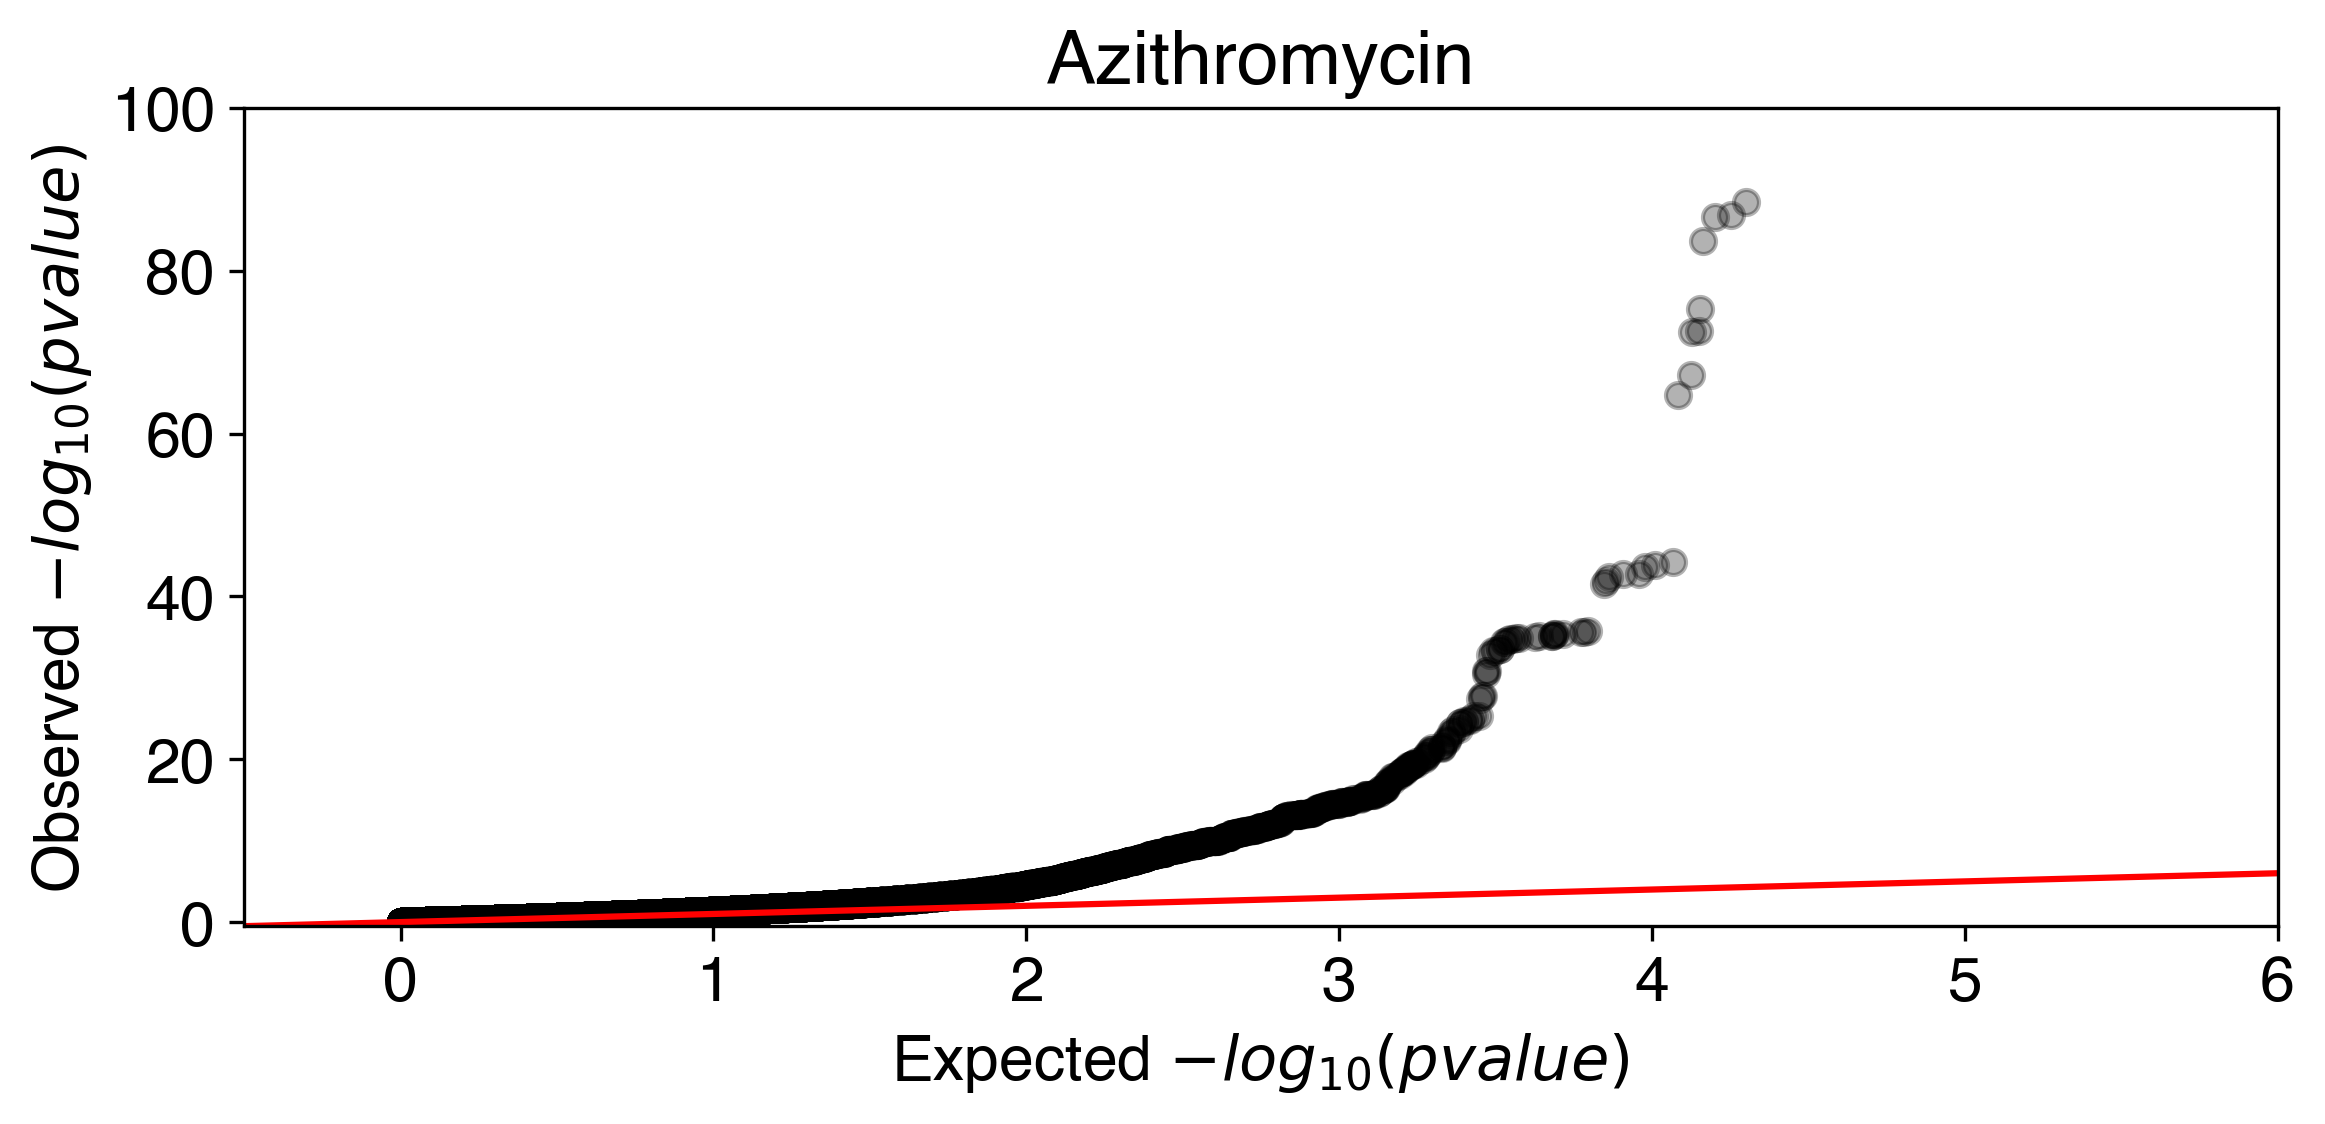

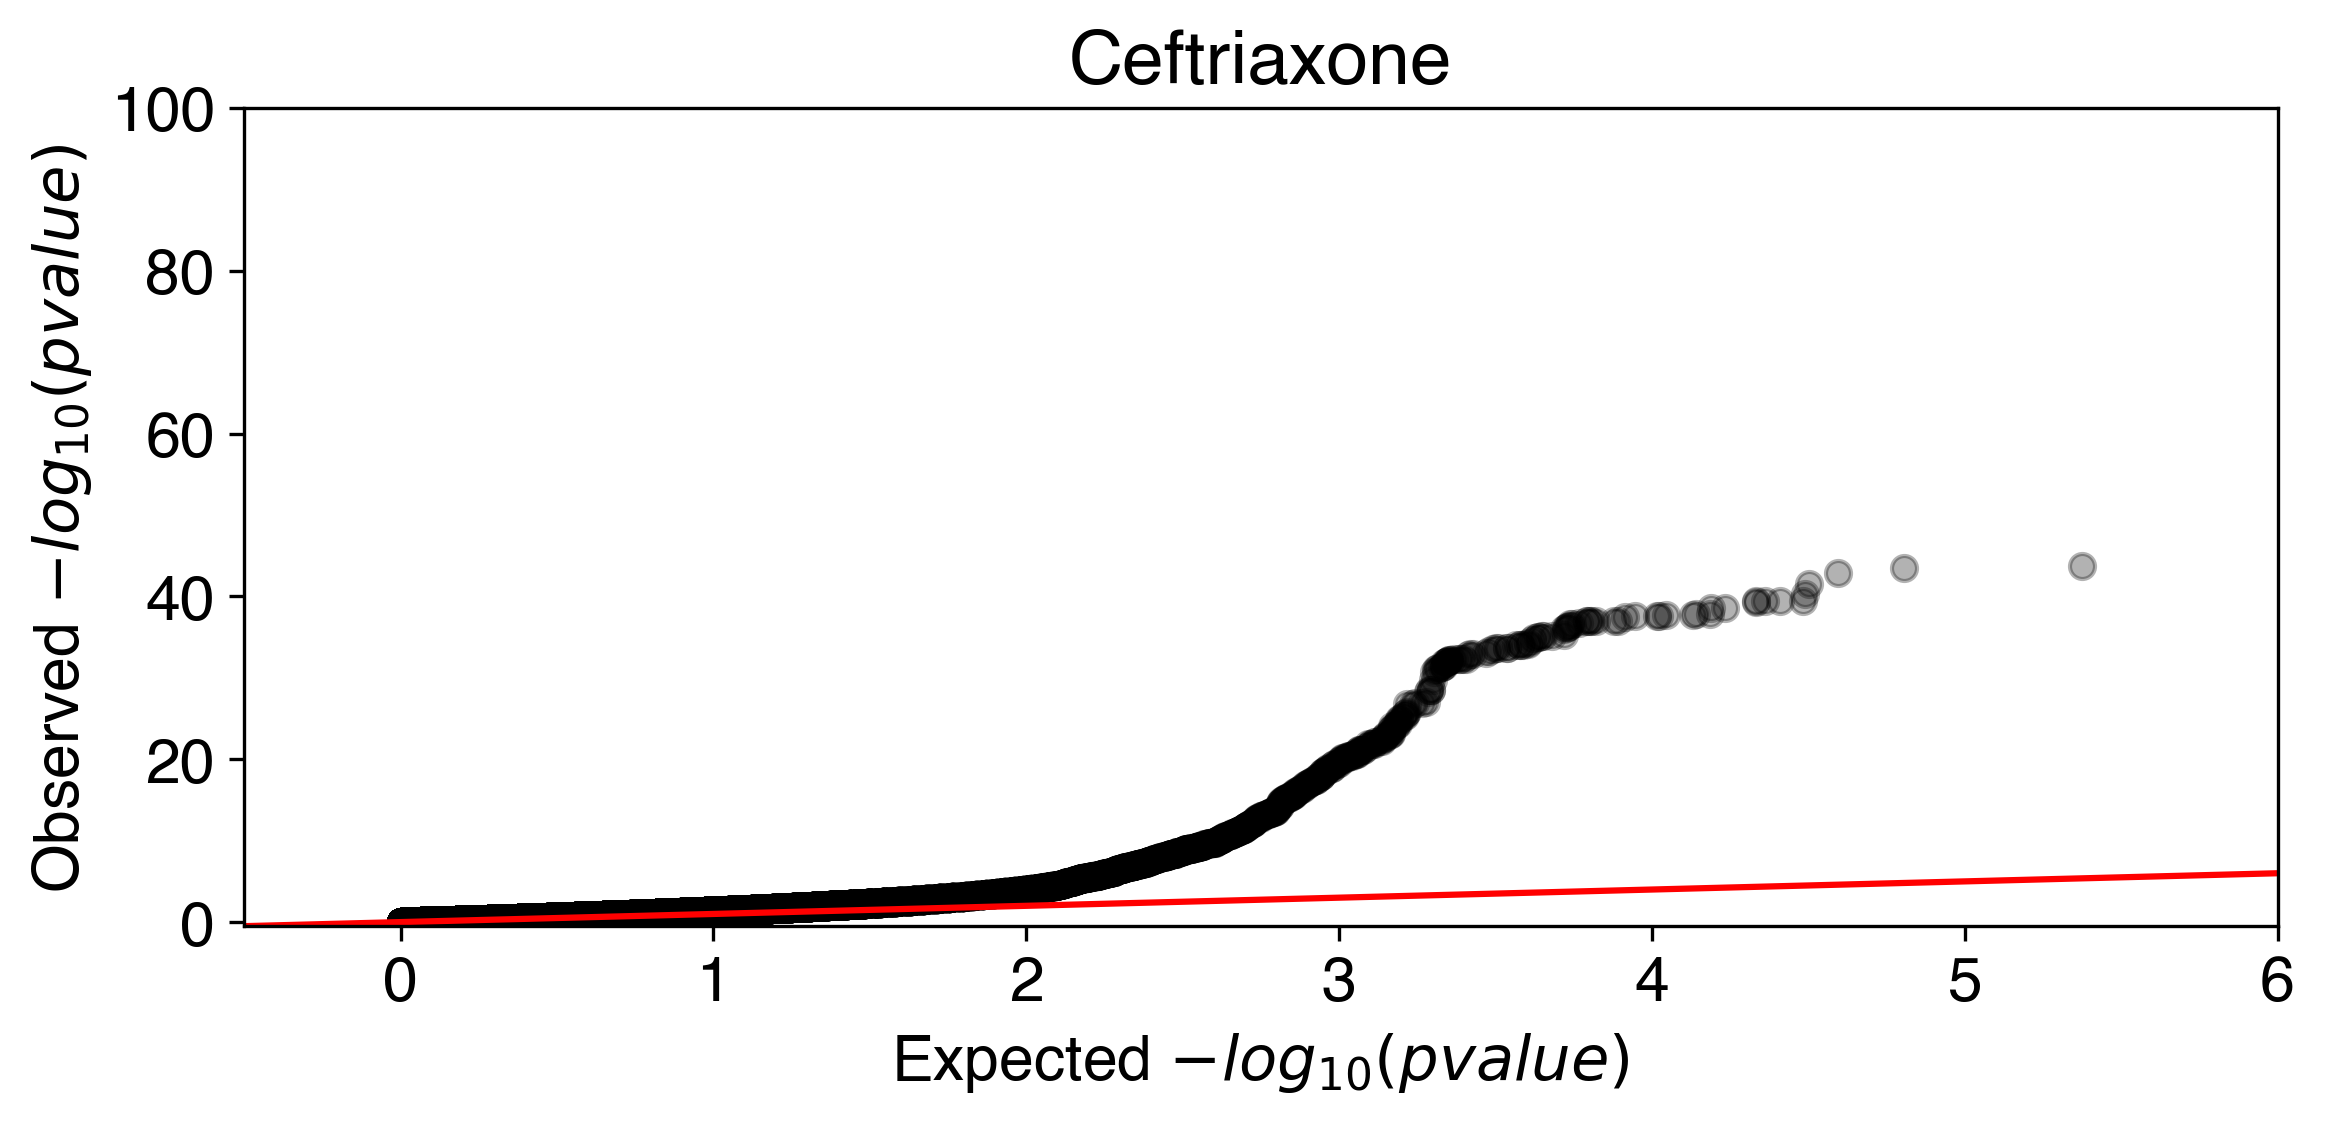

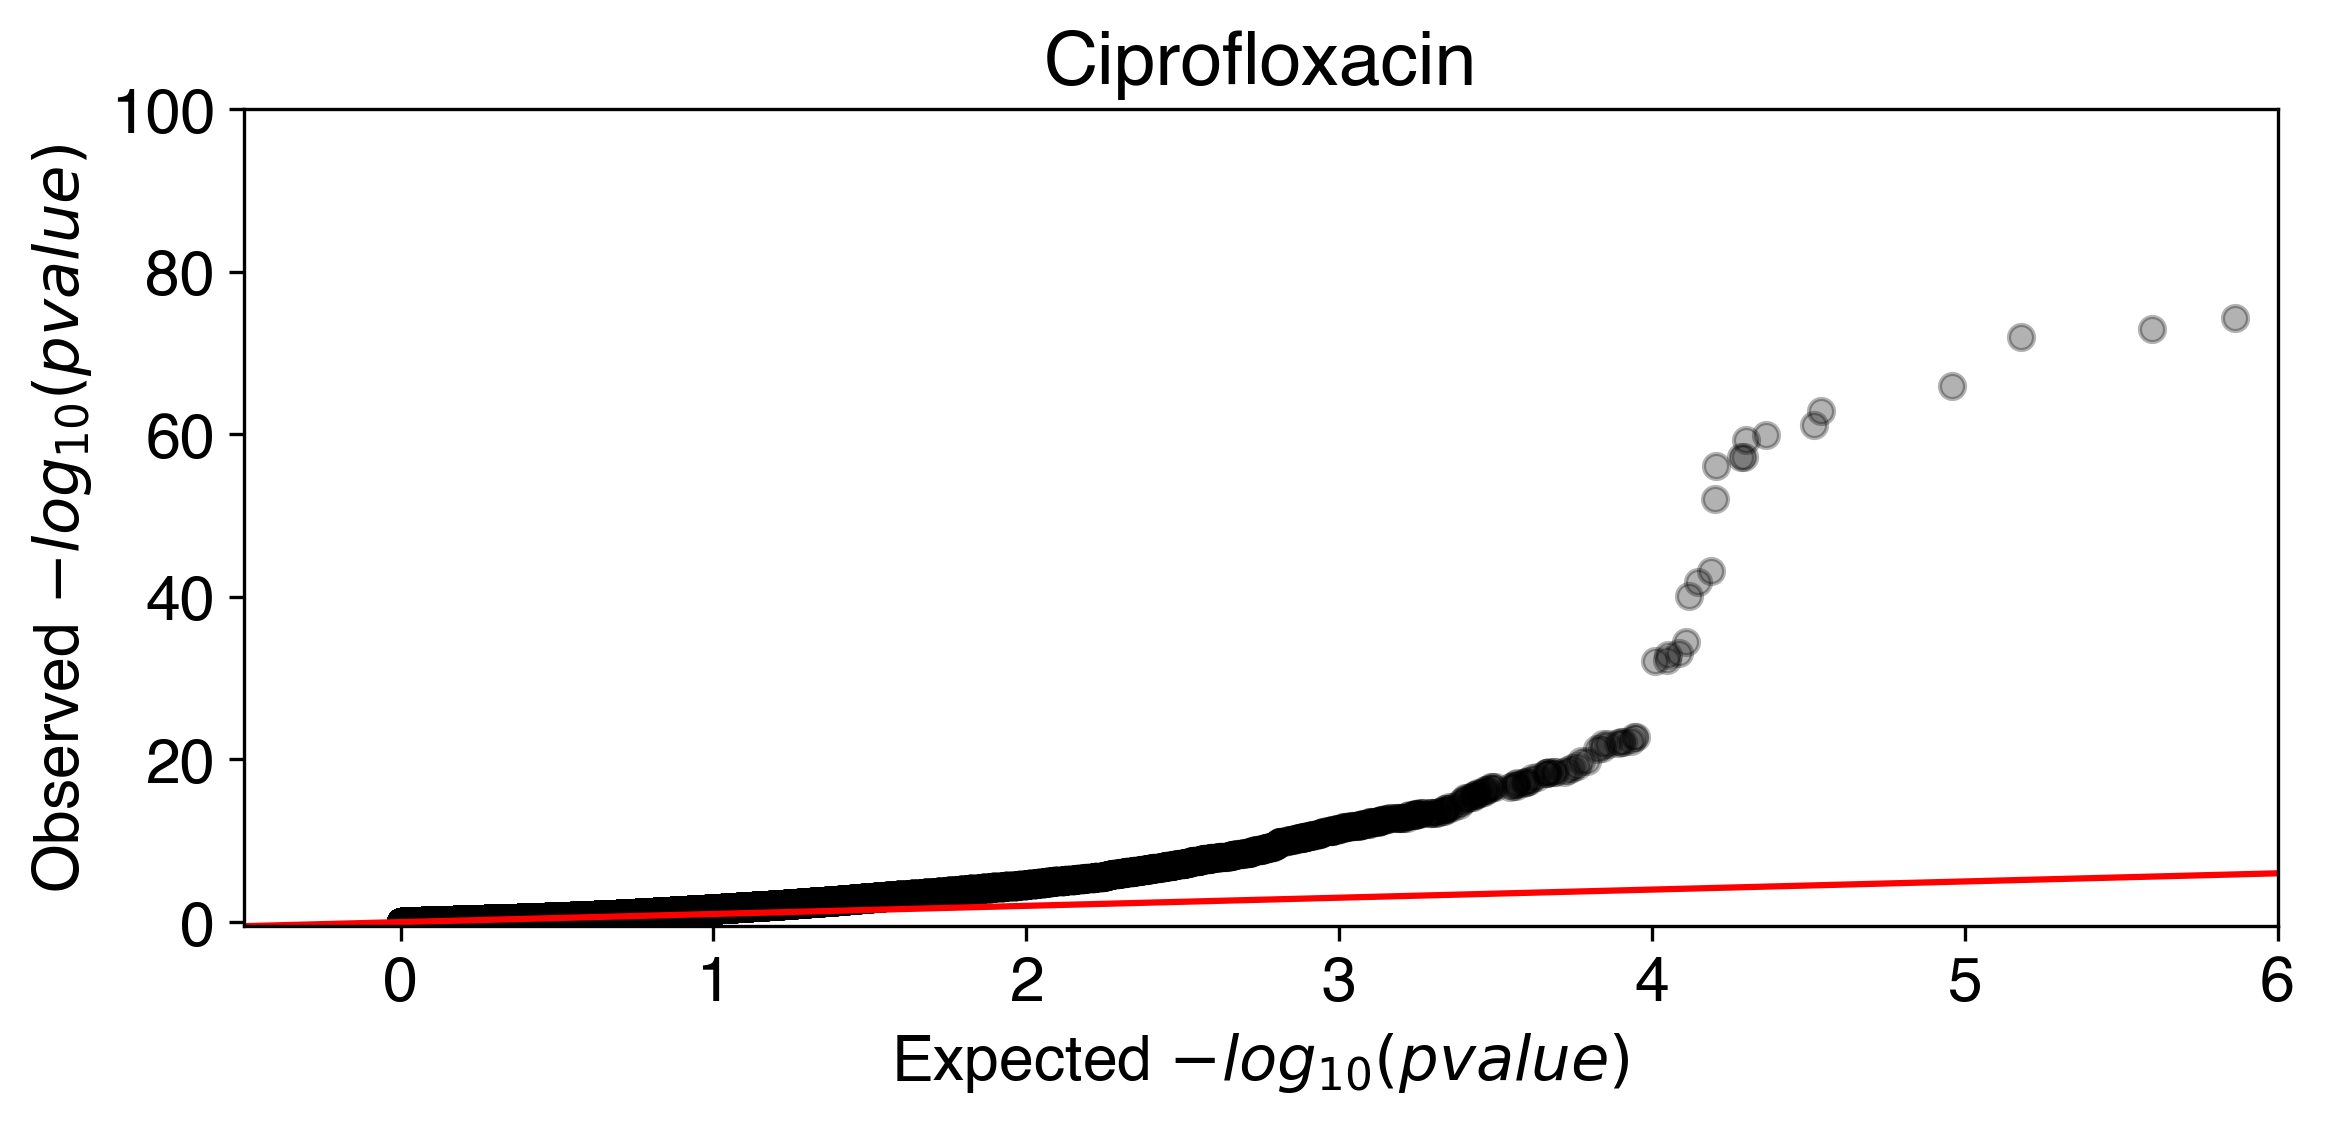

In [25]:
import sys
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

azi = 'gwas/results/azi/pyseer-AZI-cond-country.results.txt'
cro = 'gwas/results/cro/pyseer-CRO-cond-country.results.txt'
cip = 'gwas/results/cip/pyseer-CIP-cond-country.results.txt'

azi = pd.read_csv(azi, usecols=['lrt-pvalue'], sep='\t')['lrt-pvalue']
cro = pd.read_csv(cro, usecols=['lrt-pvalue'], sep='\t')['lrt-pvalue']
cip = pd.read_csv(cip, usecols=['lrt-pvalue'], sep='\t')['lrt-pvalue']

def plot_qq(m, drug, fullname):

    plt.figure(figsize=(8,4), dpi=300)
    plt.rcParams.update({'font.size': 15})
    ax = plt.subplot(111)
    
    y = -np.log10(m)
    x = -np.log10(np.random.uniform(0, 1, m.shape[0]))

    fig = sm.qqplot_2samples(y,
                             x,
                             xlabel='Expected $-log_{10}(pvalue)$',
                             ylabel='Observed $-log_{10}(pvalue)$',
                             line='45',
                             ax=ax)

    ax = fig.axes[0]
    ax.lines[0].set_color('k')
    ax.lines[0].set_alpha(0.3)
    
    ax.set_xlim(-0.5, 6)
    ax.set_ylim(-0.5, 100)
    
    ax.title.set_text(fullname)

    plt.tight_layout()
    plt.savefig('gwas/figures/{0}_qqplot.pdf'.format(drug), dpi=300)
    
plot_qq(azi, 'azi', 'Azithromycin')
plot_qq(cro, 'cro', 'Ceftriaxone')
plot_qq(cip, 'cip', 'Ciprofloxacin')

### Combined Manhattan plot (Figure 2)

We use a standard Manhattan plot to display the GWAS results for all three drugs (x-axis is mapped genomic position, y-axis is -log(p-value)). We pick up known major resistance determinants for all drugs, as well as the mtrC unitig associated with susceptibility; effect size is indicated by symbol shape. The full figure in the paper with inset with mtrARCDE operon diagram was made in Biorender and combined with the Manhattan plot in Illustrator.

In [26]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import matplotlib.ticker as mtick
from matplotlib.patches import Polygon
%matplotlib inline

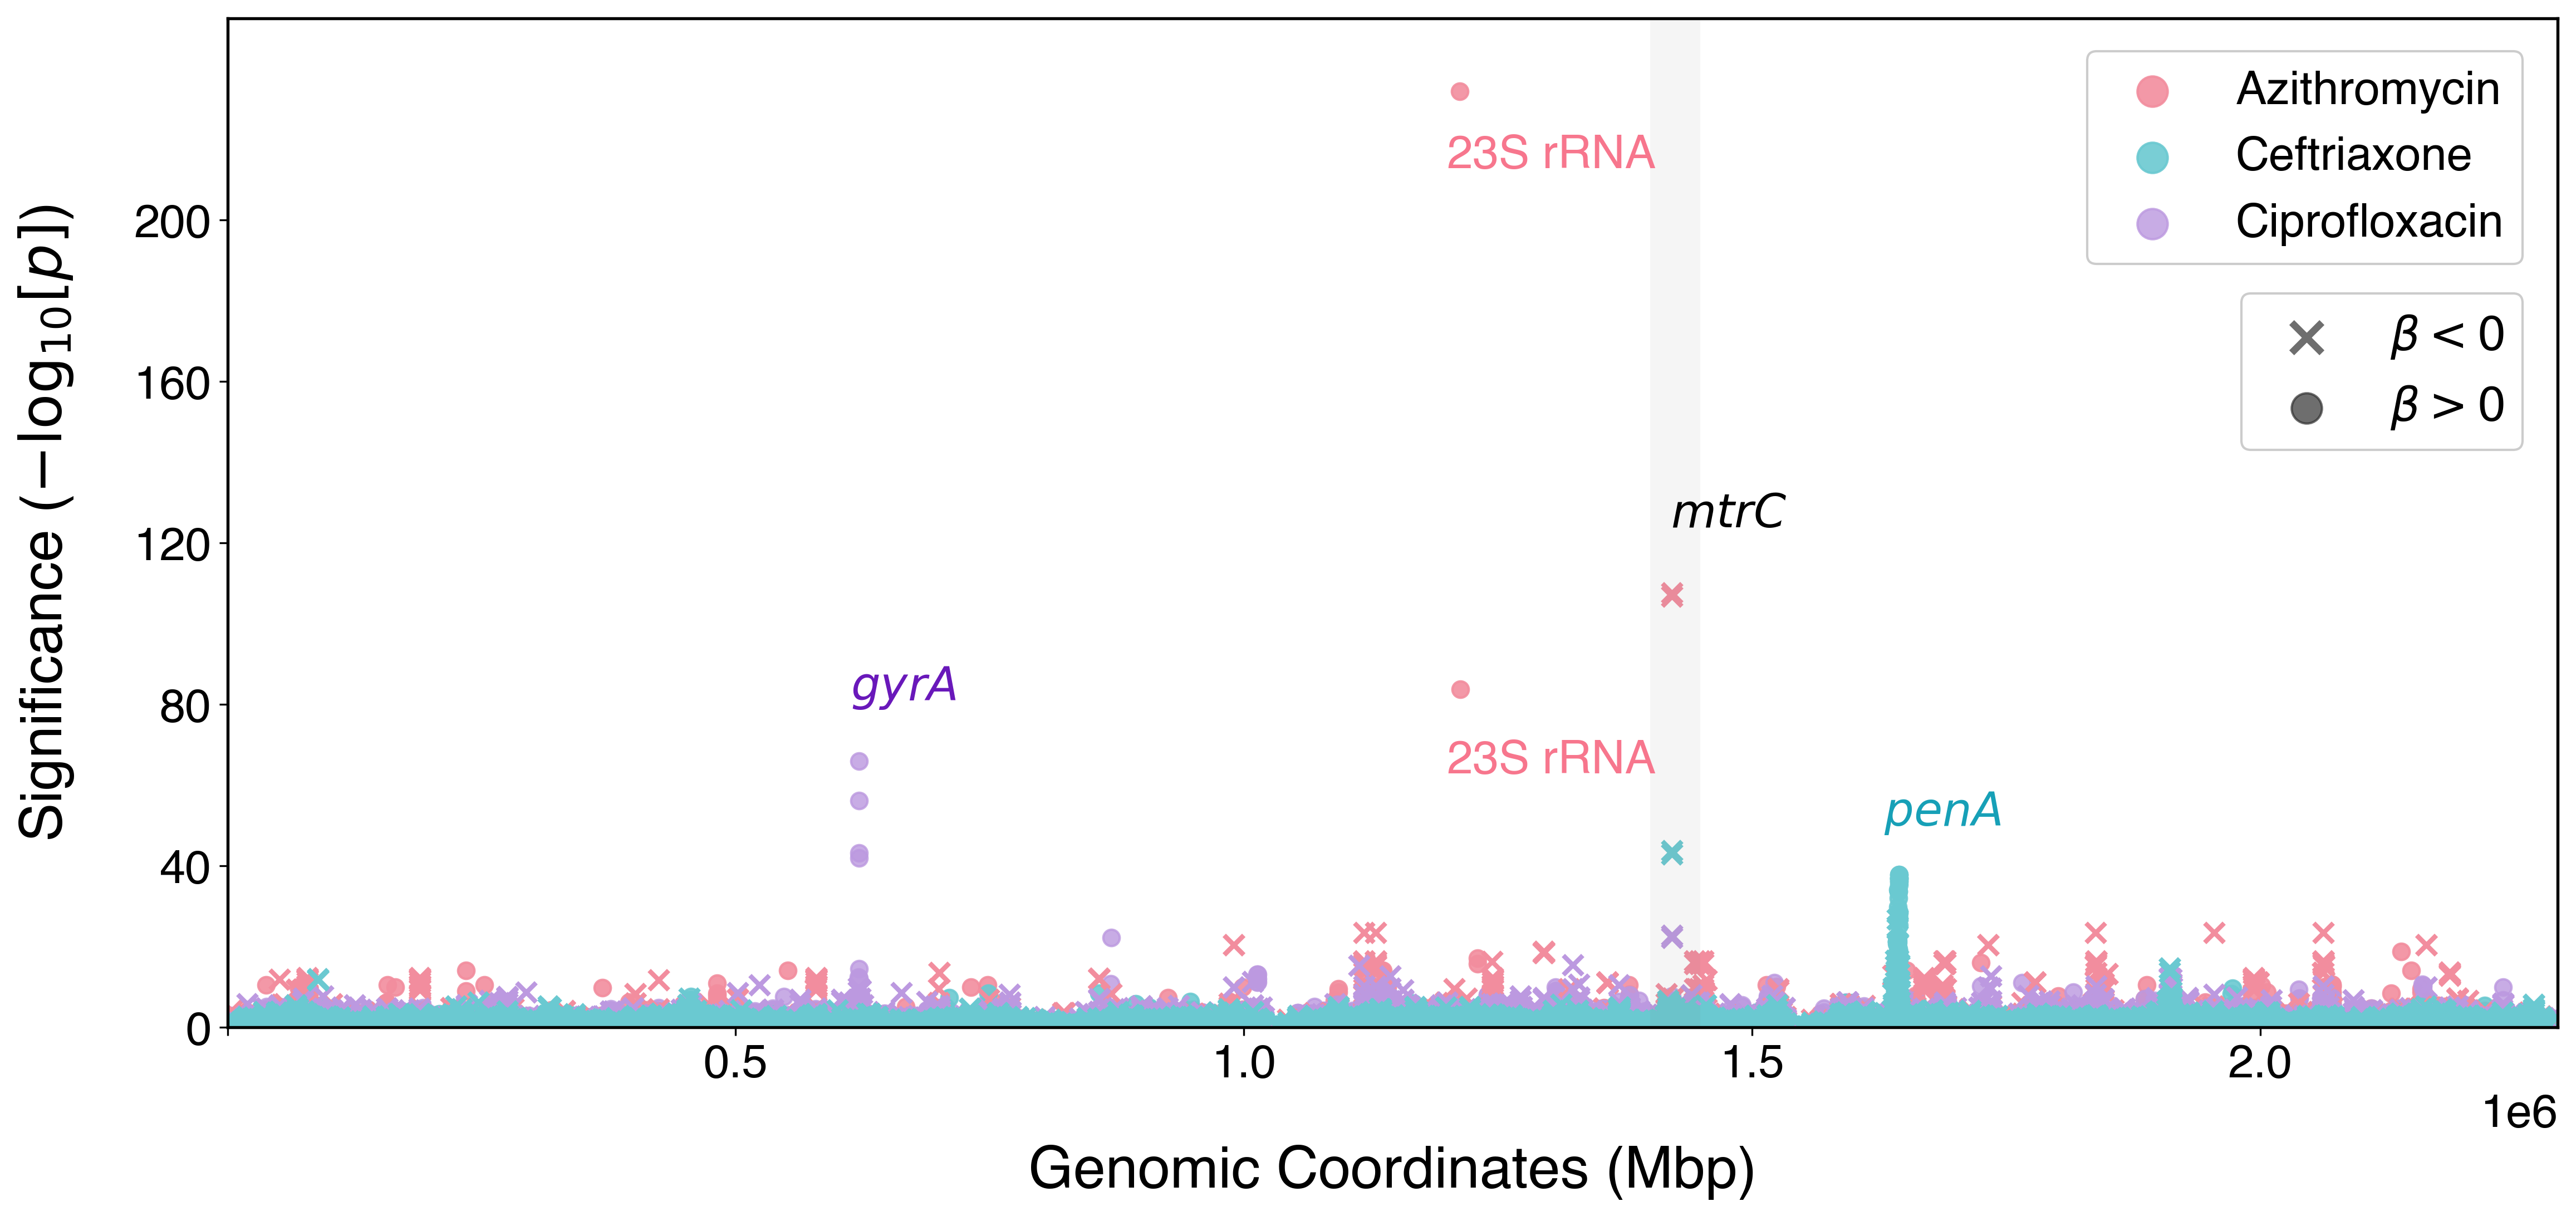

In [31]:
# Data pre-processing for plotting
azi = pd.read_csv('gwas/results/azi/pyseer-AZI-cond-country.results.mapped-WHO_F.plot', sep='\t').sort_values('log10(p)', ascending=False)
cro = pd.read_csv('gwas/results/cro/pyseer-CRO-cond-country.results.mapped-WHO_F.plot', sep='\t').sort_values('log10(p)', ascending=False)
cip = pd.read_csv('gwas/results/cip/pyseer-CIP-cond-country.results.mapped-WHO_F.plot', sep='\t').sort_values('log10(p)', ascending=False)

azi['Pos'] = azi['minLOG10(P)'].apply(lambda x: int(x.split('..')[0]))
cro['Pos'] = cro['minLOG10(P)'].apply(lambda x: int(x.split('..')[0]))
cip['Pos'] = cip['minLOG10(P)'].apply(lambda x: int(x.split('..')[0]))

azi = azi[azi['af'] <= 0.5]
cro = cro[cro['af'] <= 0.5]
cip = cip[cip['af'] <= 0.5]

# Plotting parameters
factor = 4.4
alpha = 0.9
nonsig = 0.7
lgnds = 170

numpoints = int(1e5) # Plotting all of the mapped unitigs is not necessary
pointsizes = 50
pointsizes2 = 70

plt.rcParams['axes.linewidth'] = 1.3
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'font.size': 20})
hfont = {'fontname':'Helvetica'}
plt.figure(figsize=(18,8), dpi=300)

major_ticks = np.arange(0, 230, 40)
plt.yticks(major_ticks)

# First, plot the unitigs with positive betas
a = plt.scatter('Pos', 'log10(p)', s=pointsizes, data=azi[azi['beta'] > 0].head(numpoints), alpha=alpha, color='#f28d9e', label='Azithromycin')
c = plt.scatter('Pos', 'log10(p)', s=pointsizes, data=cip[cip['beta'] > 0].head(numpoints), alpha=alpha*0.9, color='#bc99e0', label='Ciprofloxacin')
b = plt.scatter('Pos', 'log10(p)', s=pointsizes, data=cro[cro['beta'] > 0].head(numpoints), alpha=alpha, color='#6ac9d1', label='Ceftriaxone')

# Then, plot the unitigs with negative betas
plt.scatter('Pos', 'log10(p)', marker='x', s=pointsizes2, data=azi[azi['beta'] < 0].head(numpoints), alpha=1, color='#f28d9e', label='Azithromycin', linewidth=2)
plt.scatter('Pos', 'log10(p)', marker='x', s=pointsizes2, data=cip[cip['beta'] < 0].head(numpoints), alpha=1, color='#bc99e0', label='Ciprofloxacin', linewidth=2)
plt.scatter('Pos', 'log10(p)', marker='x', s=pointsizes2, data=cro[cro['beta'] < 0].head(numpoints), alpha=1, color='#6ac9d1', label='Ceftriaxone', linewidth=2)

# Resistance genes
plt.annotate(r'23S rRNA', (1.2e6, 213), color='#f7768d')
plt.annotate(r'23S rRNA', (1.2e6, 63), color='#f7768d')
plt.annotate(r'$\mathit{penA}$', (1.63e6, 50), color='#17a0b7')
plt.annotate(r'$\mathit{gyrA}$', (6.13e5, 81), color='#6918ba')

# MtrC highlight
currentAxis = plt.gca()
plt.annotate(r'$\mathit{mtrC\ }$', (1.42e6, 124), color='#000000', fontsize=20)
currentAxis.add_patch(Rectangle((1.4e6,0),4.9e4,250,linewidth=1,facecolor='#7d7d7d',alpha=0.075))

# Legend for drugs
plt.legend()
lgnd = plt.legend((a, b, c),
           ('Azithromycin','Ceftriaxone','Ciprofloxacin'),
           scatterpoints=1,
           loc='upper right',
           ncol=1,
           fontsize=20,
           framealpha=1,
           bbox_to_anchor=(0.995, 0.99))

# Adjust size of symbols in legend
lgnd.legendHandles[0]._sizes = [lgnds]
lgnd.legendHandles[1]._sizes = [lgnds]
lgnd.legendHandles[2]._sizes = [lgnds]

# Legend for effect size
l1 = plt.scatter([],[], marker = 'x', linewidth=3, s = lgnds, color='#303030', alpha=0.7)
l2 = plt.scatter([],[], s=lgnds, color='#303030', edgecolor='#303030', alpha=0.7)
labels = [r'$\beta < 0$', r'$\beta > 0$']
leg = plt.legend([l1, l2], labels, ncol=1, fontsize=20, loc='upper right', bbox_to_anchor=(0.995, 0.75), scatterpoints = 1,
                framealpha =1)
plt.gca().add_artist(lgnd)

# Axes
plt.xlim(0, 2292467)
plt.ylim(0, 250)
plt.xlabel(r'Genomic Coordinates (Mbp)', labelpad=25, fontsize=25)
plt.ylabel(r'Significance ($-\log_{10}[p]$)', labelpad=25, fontsize=25)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
xticks = plt.gca().xaxis.get_major_ticks() 
xticks[0].label1.set_visible(False)

plt.savefig('gwas/figures/combined-manhattan-plot.png', bbox_inches="tight", dpi=600)

## Efflux pump LOF & association with metadata

### Identifying LOF alleles (Supplementary Table 4)

We use a simple BLAST reference genome-based pipeline to identify putative LOF mutations in the well-characterized efflux pumps farAB, mtrCDE, norM, and macAB. We use FA1090 as the reference gene for all of these except mtrA (for which FA1090 already has a LOF allele). The BLAST database for the global dataset was the same one we used to categorize mosaic penA / mtrCDE alleles, and the validation BLAST database was built similarly using contigs from Williamson et al. 

In [86]:
import pandas as pd
from Bio import SeqIO
import os

def find_lof(gene, dataset='global'):
    
    if dataset == 'global':
        cmd = "blastn -db blast/2019-08-26_combined-contigs.fna -query efflux-lof/query/{0}-ref.fna -outfmt '6 sseqid length evalue sseq' -max_target_seqs 10000 -out efflux-lof/results/{0}-global.tsv".format(gene)
        metadata = pd.read_csv('metadata/2020-04-27_Supplementary-Table-6_Global-Strain-Collection.csv', sep=',')
        os.system(cmd)
    elif dataset == 'validation':
        cmd = "blastn -db blast/2019-09-30_australia-contigs.fna -query efflux-lof/query/{0}-ref.fna -outfmt '6 sseqid length evalue sseq' -max_target_seqs 10000 -out efflux-lof/results/{0}-validation.tsv".format(gene)
        metadata = pd.read_csv('metadata/2020-04-27_Supplementary-Table-7_Validation-Strain-Collection.csv', sep=',')
        metadata['GWAS_ID'] = metadata['Accession']
        os.system(cmd)
    
    samples = []

    for seq_record in SeqIO.parse('efflux-lof/query/{0}-ref.fna'.format(gene), "fasta"):
        fasta = seq_record.seq
        ntlen = len(fasta)
        aalen = len(fasta) / 3

    with open('efflux-lof/results/{0}-{1}.fna'.format(gene, dataset), 'w') as outfile, open('efflux-lof/results/{0}-{1}.tsv'.format(gene, dataset), 'r') as infile:
        for line in infile:
            name,length,evalue,fasta = line.rstrip().split('\t')

            if name.split('|')[0] not in list(metadata['GWAS_ID']): # Samples not included in MtrC GWAS
                continue
                
            if int(length) < ntlen-5 or int(length) > ntlen+5: # Filter for complete BLAST results
                continue

            if not fasta[0:3] in ['ATG', 'GTG', 'TTG']: # Screen out BLAST results without canonical start sites
                continue

            outfile.write('>' + name.split('|')[0] + '\n')
            outfile.write(fasta + '\n')

            if name in samples:
                print('Duplicate ' + name) # Possible gene duplication
            else:
                samples.append(name.split('|')[0])

    truncated = []
    for seq_record in SeqIO.parse('efflux-lof/results/{0}-{1}.fna'.format(gene, dataset), "fasta"):
        peptide = str(seq_record.seq.ungap('-').translate()).split('*')[0]
        if not str(seq_record.seq).startswith('ATG'):
            continue
        if len(peptide) < 0.9*aalen:
            truncated.append(seq_record.id)
            
    print('{4}\t{2}\t{0}\t{1}\t{3}%'.format(len(truncated), len(samples), gene, round(100*len(truncated)/len(samples),2), dataset))

In [87]:
find_lof('farA', 'global')
find_lof('farB', 'global')
find_lof('norM', 'global')
find_lof('macA', 'global')
find_lof('macB', 'global')
find_lof('mtrR', 'global')
find_lof('mtrA', 'global')
find_lof('mtrC', 'global')
find_lof('mtrD', 'global')
find_lof('mtrE', 'global')

find_lof('farA', 'validation')
find_lof('farB', 'validation')
find_lof('norM', 'validation')
find_lof('macA', 'validation')
find_lof('macB', 'validation')
find_lof('mtrR', 'validation')
find_lof('mtrA', 'validation')
find_lof('mtrC', 'validation')
find_lof('mtrD', 'validation')
find_lof('mtrE', 'validation')

global	farA	332	4838	6.86%
global	farB	2	4850	0.04%
global	norM	2	4852	0.04%
global	macA	1	4847	0.02%
global	macB	13	4845	0.27%
global	mtrR	386	4845	7.97%
global	mtrA	362	4842	7.48%
global	mtrC	185	4847	3.82%
global	mtrD	10	4807	0.21%
global	mtrE	0	4849	0.0%
validation	farA	225	2181	10.32%
validation	farB	1	2186	0.05%
validation	norM	0	2186	0.0%
validation	macA	0	2186	0.0%
validation	macB	0	2186	0.0%
validation	mtrR	253	2183	11.59%
validation	mtrA	85	2186	3.89%
validation	mtrC	35	2186	1.6%
validation	mtrD	2	2185	0.09%
validation	mtrE	0	2186	0.0%


This almost exactly reproduces Supplementary Table 5, but we additionally adjust our LOF predictions for MtrA depending on whether or not there exist epistatic MtrCDE upregulation mutations (Mtr_Upregulation column in the strain tables). The reasoning is that previous studies have shown MtrA LOF (i.e., no induction effect) will have little effect if the MtrCDE operon is already overexpressed due to e.g. MtrR repressor mutations, so MtrA LOF versus WT in this context is "masked".

### Association with site of infection (Figure 3)

We run Fisher's exact test to check for an association between site of infection and LOF alleles. The code below reproduces the results in the Supplemnetary Text showing significant associations by Fisher's exact test.

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R -w 6 -h 5 --units in -r 600

library(dplyr)
library(tidyr)
library(tibble)
library(ggplot2)
library(forcats)

metadata <- read.table("metadata/2020-04-27_Supplementary-Table-6_Global-Strain-Collection.csv", sep = ",", comment.char = "!", header = T, stringsAsFactors = F, na.strings=c("", "NA"))

calc_sites <- function(gene) {
    
    site <- metadata %>% 
        filter(Origin != "Eye" & Origin != "Other" & !is.na(!!gene) & !is.na(Origin)) %>%
        count(Origin, !!gene) %>%
        spread(Origin, n, fill = 0) %>%
        column_to_rownames(quo_name(gene))

    site.fisher <- fisher.test(site)
    cat(sprintf("### Site of infection and %s LOF ###\n\n", quo_name(gene)))
    print(site)
    print(site.fisher)
    
    # Uncomment for pairwise comparisons between sites of infection
    #print(fisher.test(data.frame(site['Pharynx'], site['Cervix'])))
    print(fisher.test(data.frame(site['Urethra'], site['Cervix'])))
    #print(fisher.test(data.frame(site['Rectum'], site['Cervix'])))
    #print(fisher.test(data.frame(site['Pharynx'], site['Urethra'])))
    #print(fisher.test(data.frame(site['Pharynx'], site['Rectum'])))
    #print(fisher.test(data.frame(site['Urethra'], site['Rectum'])))
}

calc_sites(quo(MtrC))
calc_sites(quo(MtrA))
calc_sites(quo(FarA))

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### Site of infection and MtrC LOF ###

       Cervix Pharynx Rectum Urethra
Intact    113     103    242    2167
LOF        16       3      4      82

	Fisher's Exact Test for Count Data

data:  site
p-value = 6.487e-05
alternative hypothesis: two.sided


	Fisher's Exact Test for Count Data

data:  data.frame(site["Urethra"], site["Cervix"])
p-value = 4.706e-05
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.975147 6.700926
sample estimates:
odds ratio 
  3.738688 

### Site of infection and MtrA LOF ###

          Cervix Pharynx Rectum Urethra
Inducible    104     102    242    2187
LOF           25       4      4      61

	Fisher's Exact Test for Count Data

data:  site
p-value = 1.636e-12
alternative hypothesis: two.sided


	Fisher's Exact Test for Count Data

data:  data.frame(site["Urethra"], site["Cervix"])
p-value = 4.606e-13
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  4.963578 14.57018

To visualize the proportions for the sites of infection, we use normalized bar plots; the code below reproduces the data in Figure 3b (significance bars were added in Illustrator).

R[write to console]: Saving 6 x 5 in image

R[write to console]: Saving 6 x 5 in image

R[write to console]: Saving 6 x 5 in image



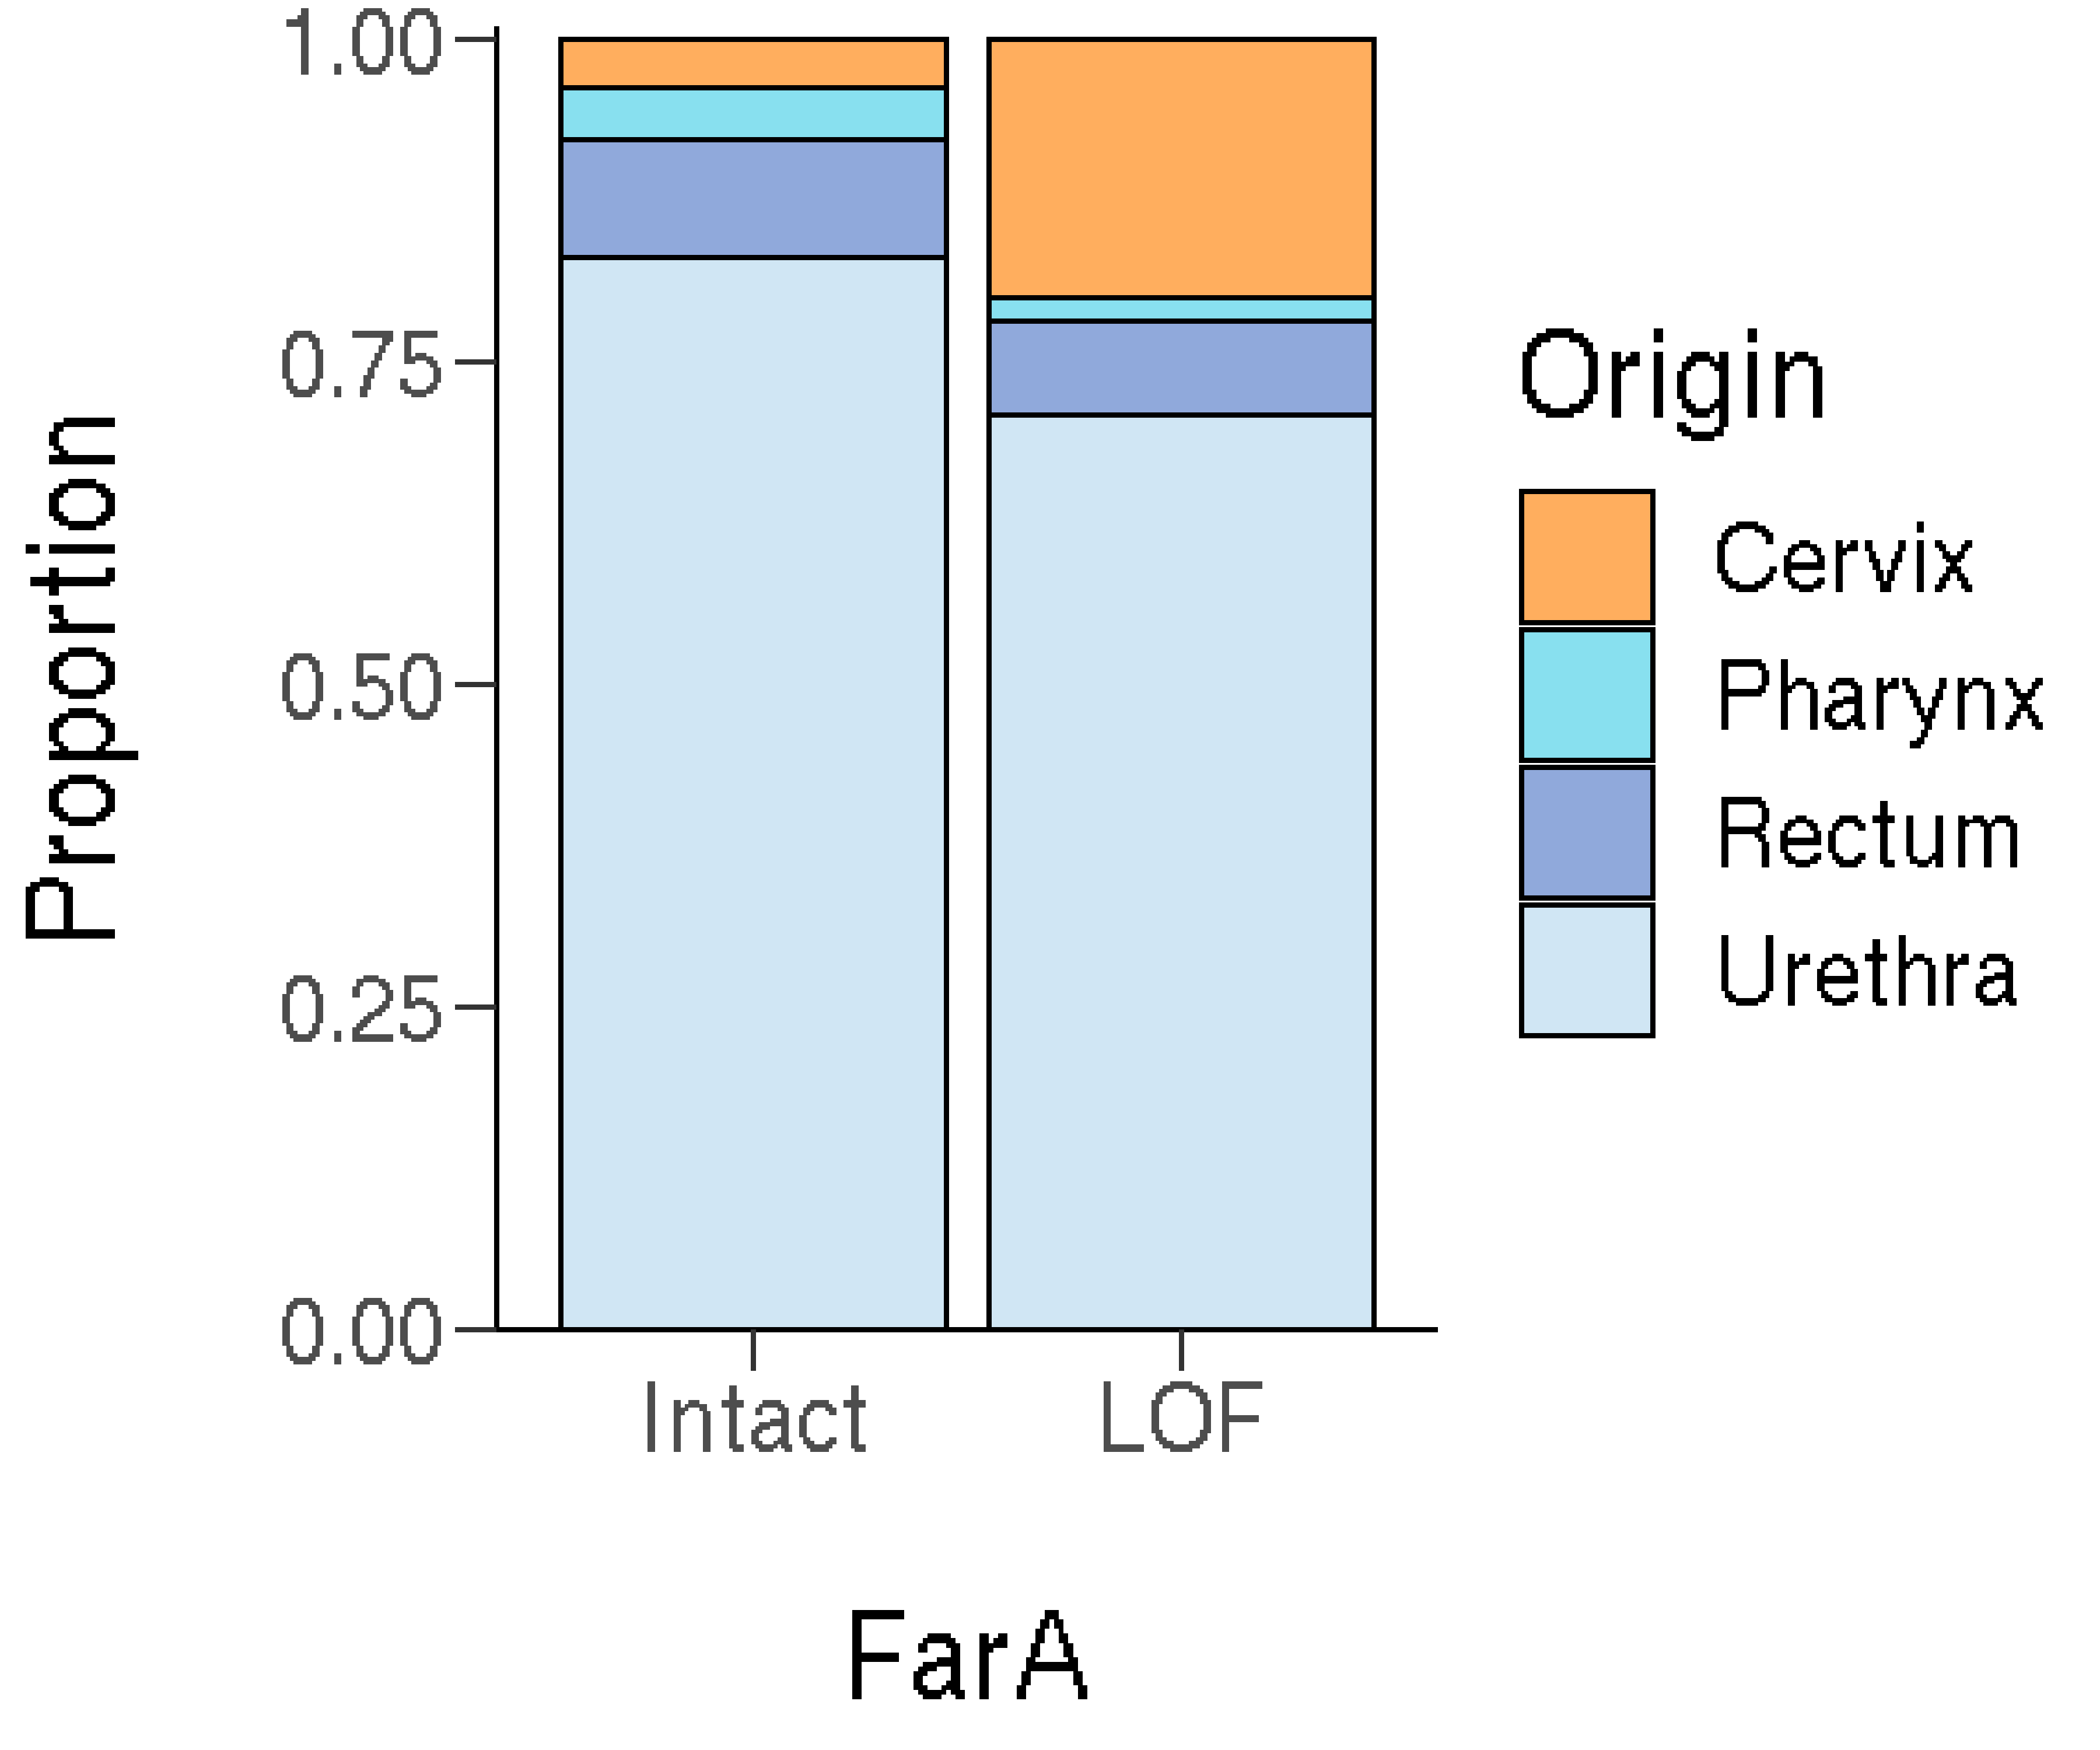

In [78]:
%%R -w 6 -h 5 --units in -r 600

library(dplyr)
library(tidyr)
library(tibble)
library(ggplot2)
library(forcats)

metadata <- read.table("metadata/2020-04-27_Supplementary-Table-6_Global-Strain-Collection.csv", sep = ",", comment.char = "!", header = T, stringsAsFactors = F, na.strings=c("", "NA"))

plot_sites <- function(gene) {
    
    colors <- c("#ffae5e", "#88e0ef", "#90a9db", "#d0e6f4")

    barplot <- metadata %>%
        filter(Origin != "Eye" & Origin != "Other" & !is.na(!!gene) & !is.na(Origin)) %>%
        ggplot(aes(!!gene, fill = Origin)) +
        geom_bar(position = "fill", color = "black") +
        scale_fill_manual(values = colors) +
        xlab(sprintf("\n%s", quo_name(gene))) +
        ylab("Proportion\n") +
        theme_classic() + 
        theme(text = element_text(size = 24)) +
        scale_y_continuous(expand = c(0, 0), limits = c(0, 1.01)) +
        theme(axis.ticks.length = unit(0.3, "cm")) +
        theme(legend.key.size=unit(1.0, "cm"))
    ggsave(sprintf("metadata-assoc/global/%s-LOF-sites-barplot.pdf", quo_name(gene)))
    barplot
}

plot_sites(quo(MtrC))
plot_sites(quo(MtrA))
plot_sites(quo(FarA))


To confirm these findings, we checked the association for site of infection with LOF alleles in the validation dataset.

In [81]:
%%R -w 6 -h 5 --units in -r 600

library(dplyr)
library(tidyr)
library(tibble)
library(ggplot2)
library(forcats)

metadata <- read.table("metadata/2020-04-27_Supplementary-Table-7_Validation-Strain-Collection.csv", sep = ",", comment.char = "!", header = T, stringsAsFactors = F, na.strings=c("", "NA"))

calc_sites <- function(gene) {
    
    site <- metadata %>% 
        filter(Origin != "Eye" & Origin != "Other" &  Origin != "Urine" &  Origin != "Joint" & !is.na(!!gene) & !is.na(Origin)) %>%
        count(Origin, !!gene) %>%
        spread(Origin, n, fill = 0) %>%
        column_to_rownames(quo_name(gene))

    site.fisher <- fisher.test(site)
    cat(sprintf("### Site of infection and %s LOF ###\n\n", quo_name(gene)))
    print(site)
    print(site.fisher)
    
    # Uncomment for pairwise comparisons between sites of infection
    #print(fisher.test(data.frame(site['Pharynx'], site['Cervix'])))
    #print(fisher.test(data.frame(site['Urethra'], site['Cervix'])))
    #print(fisher.test(data.frame(site['Rectum'], site['Cervix'])))
    #print(fisher.test(data.frame(site['Pharynx'], site['Urethra'])))
    #print(fisher.test(data.frame(site['Pharynx'], site['Rectum'])))
    #print(fisher.test(data.frame(site['Urethra'], site['Rectum'])))
}

calc_sites(quo(MtrC))
calc_sites(quo(FarA))

### Site of infection and MtrC LOF ###

       Cervix Pharynx Rectum Urethra
Intact    218     383    625     867
LOF         9       3      7      15

	Fisher's Exact Test for Count Data

data:  site
p-value = 0.02561
alternative hypothesis: two.sided

### Site of infection and FarA LOF ###

       Cervix Pharynx Rectum Urethra
Intact    160     354    609     781
LOF        67      31     21      98

	Fisher's Exact Test for Count Data

data:  site
p-value < 2.2e-16
alternative hypothesis: two.sided



#### Aggregating across efflux pump mutations
Here, we assessed how many isolates (stratified by site of infection) had any of the previously characterized LOF mutations. This was one of the most interesting takeaways: that ~1/3 of cervical strains in both global and validation datasets had some sort of efflux pump downregulation (LOF mutation in either mtrC, mtrA, or farA).

In [56]:
import pandas as pd, numpy as np
from collections import Counter

metadata = pd.read_csv('metadata/2020-04-27_Supplementary-Table-6_Global-Strain-Collection.csv')
metadata['LOF'] = np.where((metadata['MtrC']=='LOF') | (metadata['FarA']=='LOF') | (metadata['MtrA']=='LOF'), 'LOF', 'WT')

for site in ['Cervix', 'Urethra', 'Rectum', 'Pharynx']:
    counts = Counter(metadata[metadata['Origin'] == site]['LOF'])
    print('{0}: {1:.3f}'.format(site, counts['LOF']/(counts['LOF'] + counts['WT'])))

Cervix: 0.426
Urethra: 0.096
Rectum: 0.073
Pharynx: 0.094


In [54]:
import pandas as pd, numpy as np
from collections import Counter

metadata = pd.read_csv('metadata/2020-04-27_Supplementary-Table-7_Validation-Strain-Collection.csv')
metadata['LOF'] = np.where((metadata['MtrC']=='LOF') | (metadata['FarA']=='LOF'), 'LOF', 'WT')

for site in ['Cervix', 'Urethra', 'Rectum', 'Pharynx']:
    counts = Counter(metadata[metadata['Origin'] == site]['LOF'])
    print('{0}: {1:.3f}'.format(site, counts['LOF']/(counts['LOF'] + counts['WT'])))

Cervix: 0.326
Urethra: 0.126
Rectum: 0.044
Pharynx: 0.085


### Association with sexual orientation (Figure 3)

We also assess the association of the LOF mutations with patient sexual orientation. In some studies, the same patient was sampled at multiple sites on the same visit. We treat these multiple isolates independently in the site of infection statistical tests but reasoned that it would be best to keep only one representative isolate per patient for the sexual orientation statistics. Otherwise, the statistics and figures are conducted similarly to the site of infection section.

In [1]:
%load_ext rpy2.ipython

In [3]:
%%R -w 6 -h 5 --units in -r 600

library(dplyr)
library(tidyr)
library(tibble)
library(ggplot2)
library(forcats)

metadata <- read.table("metadata/2020-04-27_Supplementary-Table-6_Global-Strain-Collection.csv", sep = ",", comment.char = "!", header = T, stringsAsFactors = F, na.strings=c("", "NA"))

calc_sexor <- function(gene) {

    duplicate_patients <- c("25825_2#140", "21242_4#45", "25825_2#169", 
                              "25818_2#4", "25825_2#16", "25825_2#27", "21242_4#133", 
                              "25818_2#269", "21242_3#42", "25818_2#292", "25818_2#305", 
                              "21242_3#115", "21242_3#127", "21242_4#51", "25825_2#186", 
                              "25825_2#187", "25818_2#198", "21242_3#80", "25818_3#364",
                              "21242_3#166", "25825_2#160", "25818_3#285", "25818_3#325", 
                              "25825_2#91", "25825_2#162", "25818_2#214", "21485_4#33",
                              "ERR2133899", "ERR2133900", "ERR2133902", "ERR2133906", 
                              "ERR2133908", "ERR2133910", "ERR2133912", "ERR2133916", 
                              "ERR2133919", "ERR2133921", "ERR2133925", "ERR2133947", 
                              "ERR2133952", "ERR2133954", "ERR2133955", "ERR2133958", 
                              "ERR2133961", "ERR2133964", "ERR2133968", "ERR2133970", 
                              "ERR2133977", "ERR2133980", "ERR2133983", "ERR2133985")

    sexor.filter <- metadata %>% 
        filter(Orientation == "MSM" | Orientation == "MSW" | Orientation == "WSM" | Orientation == "MSMW") %>%
        filter(!is.na(!!gene)) %>% 
        filter(!is.na(Orientation)) %>%
        filter(!GWAS_ID %in% duplicate_patients) 

    sexor.filter.table <- sexor.filter %>%
        count(Orientation, !!gene) %>%
        mutate(Orientation = fct_rev(Orientation)) %>%
        spread(Orientation, n, fill = 0) %>%
        column_to_rownames(quo_name(gene))

    cat(sprintf("### Sexual orientation and %s LOF ###\n\n", quo_name(gene)))
    print(sexor.filter.table)
    print(fisher.test(sexor.filter.table))
    print(fisher.test(data.frame(sexor.filter.table['MSM'], sexor.filter.table['MSW'])))
}

calc_sexor(quo(MtrC))
calc_sexor(quo(MtrA))
calc_sexor(quo(FarA))

### Sexual orientation and MtrC LOF ###

       WSM MSW MSMW  MSM
Intact  30 598  123 1158
LOF      3  28    4   31

	Fisher's Exact Test for Count Data

data:  sexor.filter.table
p-value = 0.04021
alternative hypothesis: two.sided


	Fisher's Exact Test for Count Data

data:  data.frame(sexor.filter.table["MSM"], sexor.filter.table["MSW"])
p-value = 0.037
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.000244 3.044423
sample estimates:
odds ratio 
  1.748554 

### Sexual orientation and MtrA LOF ###

          WSM MSW MSMW  MSM
Inducible  27 598  127 1181
LOF         6  28    0    7

	Fisher's Exact Test for Count Data

data:  sexor.filter.table
p-value = 1.805e-11
alternative hypothesis: two.sided


	Fisher's Exact Test for Count Data

data:  data.frame(sexor.filter.table["MSM"], sexor.filter.table["MSW"])
p-value = 3.372e-08
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  3.342817 21.522590
samp

R[write to console]: Saving 6 x 5 in image

R[write to console]: Saving 6 x 5 in image

R[write to console]: Saving 6 x 5 in image



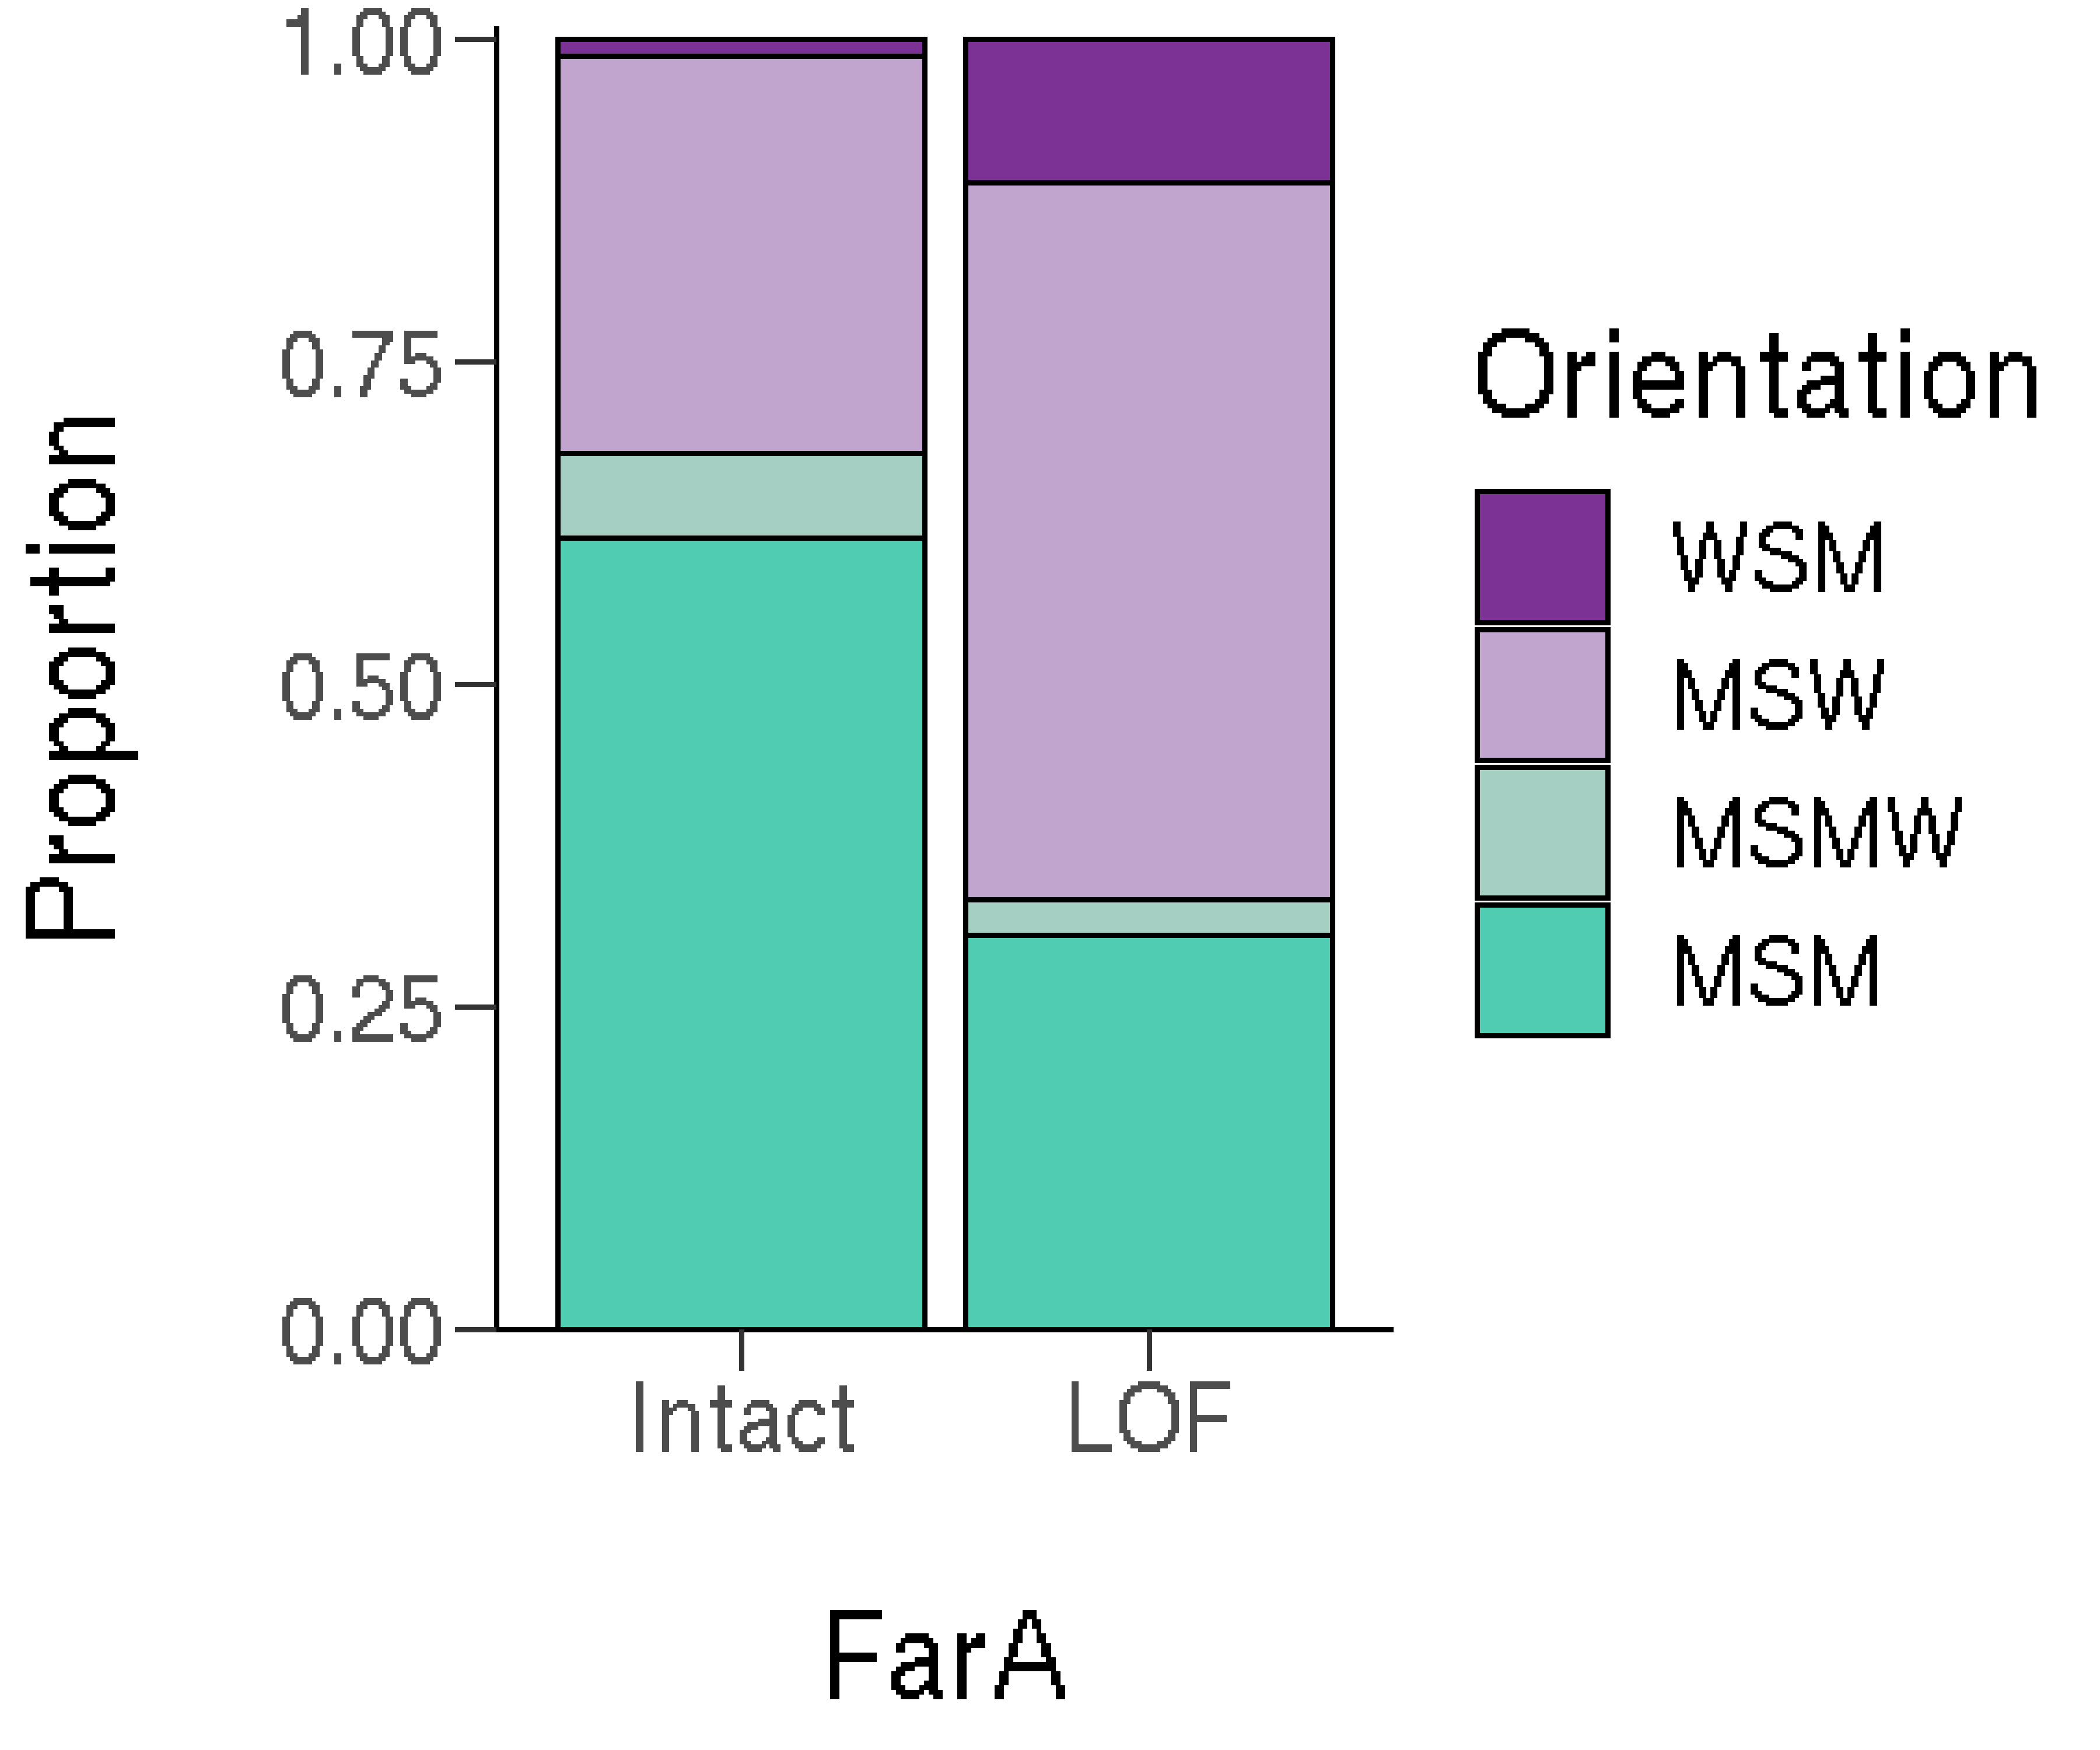

In [50]:
%%R -w 6 -h 5 --units in -r 600

library(dplyr)
library(tidyr)
library(tibble)
library(ggplot2)
library(forcats)

metadata <- read.table("metadata/2020-04-27_Supplementary-Table-6_Global-Strain-Collection.csv", sep = ",", comment.char = "!", header = T, stringsAsFactors = F, na.strings=c("", "NA"))

plot_sexor <- function(gene) {
    
    colors <- c("#7b3294", "#c2a5cf", "#a5cfc2","#4fccb1", "#ffffff")
    duplicate_patients <- c("25825_2#140", "21242_4#45", "25825_2#169", 
                              "25818_2#4", "25825_2#16", "25825_2#27", "21242_4#133", 
                              "25818_2#269", "21242_3#42", "25818_2#292", "25818_2#305", 
                              "21242_3#115", "21242_3#127", "21242_4#51", "25825_2#186", 
                              "25825_2#187", "25818_2#198", "21242_3#80", "25818_3#364",
                              "21242_3#166", "25825_2#160", "25818_3#285", "25818_3#325", 
                              "25825_2#91", "25825_2#162", "25818_2#214", "21485_4#33",
                              "ERR2133899", "ERR2133900", "ERR2133902", "ERR2133906", 
                              "ERR2133908", "ERR2133910", "ERR2133912", "ERR2133916", 
                              "ERR2133919", "ERR2133921", "ERR2133925", "ERR2133947", 
                              "ERR2133952", "ERR2133954", "ERR2133955", "ERR2133958", 
                              "ERR2133961", "ERR2133964", "ERR2133968", "ERR2133970", 
                              "ERR2133977", "ERR2133980", "ERR2133983", "ERR2133985")

    sexor.filter <- metadata %>% 
        filter(Orientation == "MSM" | Orientation == "MSW" | Orientation == "WSM" | Orientation == "MSMW") %>%
        filter(!is.na(!!gene)) %>% 
        filter(!is.na(Orientation)) %>%
        filter(!GWAS_ID %in% duplicate_patients) 
    
    barplot <- sexor.filter %>%
        mutate(Orientation = fct_rev(Orientation)) %>%
        ggplot(aes(!!gene, fill = Orientation)) +
        geom_bar(position = "fill", color = "black") +
        scale_fill_manual(values = colors) +
        xlab(sprintf("\n%s", quo_name(gene))) +
        ylab("Proportion\n") +
        theme_classic() + 
        theme(text = element_text(size = 24)) +
        scale_y_continuous(expand = c(0, 0), limits = c(0, 1.01)) +
        theme(axis.ticks.length = unit(0.3, "cm")) +
        theme(legend.key.size=unit(1.0, "cm"))
    ggsave(sprintf("metadata-assoc/global/%s-LOF-sexor-barplot.pdf", quo_name(gene)))
    barplot
}

plot_sexor(quo(MtrC))
plot_sexor(quo(MtrA))
plot_sexor(quo(FarA))

We validate these findings as well in the validation dataset:

In [48]:
%%R -w 6 -h 5 --units in -r 600

library(dplyr)
library(tidyr)
library(tibble)
library(ggplot2)
library(forcats)

metadata <- read.table("metadata/2020-04-27_Supplementary-Table-7_Validation-Strain-Collection.csv", sep = ",", comment.char = "!", header = T, stringsAsFactors = F, na.strings=c("", "NA"))

calc_sexor <- function(gene) {

    sexor.filter <- metadata %>% 
        filter(Orientation == "MSM" | Orientation == "MSW" | Orientation == "WSM" | Orientation == "MSMW") %>%
        filter(!is.na(!!gene)) %>% 
        filter(!is.na(Orientation))
    
    sexor.filter.table <- sexor.filter %>%
        count(Orientation, !!gene) %>%
        mutate(Orientation = fct_rev(Orientation)) %>%
        spread(Orientation, n, fill = 0) %>%
        column_to_rownames(quo_name(gene))

    cat(sprintf("### Sexual orientation and %s LOF ###\n\n", quo_name(gene)))
    print(sexor.filter.table)
    print(fisher.test(sexor.filter.table))
}

calc_sexor(quo(MtrC))
calc_sexor(quo(FarA))

### Sexual orientation and MtrC LOF ###

       WSM MSW  MSM
Intact 268 243 1424
LOF     10   4   17

	Fisher's Exact Test for Count Data

data:  sexor.filter.table
p-value = 0.01803
alternative hypothesis: two.sided

### Sexual orientation and FarA LOF ###

       WSM MSW  MSM
Intact 197 186 1386
LOF     81  60   51

	Fisher's Exact Test for Count Data

data:  sexor.filter.table
p-value < 2.2e-16
alternative hypothesis: two.sided



## N. meningitidis analysis (Figure 4)

We then extended our findings by analyzing a urogenital clade of N. meningitidis for LOF mutations, matching these strains by geography and population structure to other strains in the PubMLST database to obtain controls.

### Dataset and Phylogenetics

We downloaded assemblies of all North American ST-11 N. meningitidis strains from PubMLST (n=456; accessed 2019-09-03). We annotated them with Prokka and generated a core-genome maximum likelihood phylogeny using Roary (flags -z -e -n -v -s -i 92). The result of all this will be a newick tree, which we've provided in 'nmening/NAmerica-ST11-US-NmU-Clade.newick'. We also made a BLAST database to run the LOF pipeline above to identify MtrC LOFs. Metadata were acquired for the US NmU Clade from Retchless et al.

### LOF calling

We used a reference sequence for MtrC from one of the PubMLST controls (Name: M21273, PubMLST ID: 338) to run the BLAST-based LOF pipeline.

In [109]:
import pandas as pd
from Bio import SeqIO
import os

def find_mening_lof(gene):
    
    cmd = "blastn -db blast/2019-09-10_ST11-contigs.fna -query nmening/Nm-{0}-ref.fna -outfmt '6 sseqid length evalue sseq' -max_target_seqs 10000 -out nmening/Nm-{0}.tsv".format(gene)
    os.system(cmd)
    samples = []

    for seq_record in SeqIO.parse('nmening/Nm-{0}-ref.fna'.format(gene), "fasta"):
        fasta = seq_record.seq
        ntlen = len(fasta)
        aalen = len(fasta) / 3

    with open('nmening/Nm-{0}.fna'.format(gene), 'w') as outfile, open('nmening/Nm-{0}.tsv'.format(gene), 'r') as infile:
        for line in infile:
            name,length,evalue,fasta = line.rstrip().split('\t')

            if not fasta[0:3] in ['ATG', 'GTG', 'TTG']: # Screen out BLAST results without canonical start sites
                continue

            outfile.write('>' + name.split('|')[0] + '\n')
            outfile.write(fasta + '\n')

            if name in samples:
                print('Duplicate ' + name) # Possible gene duplication
            else:
                samples.append(name.split('|')[0])

    truncated = []
    for seq_record in SeqIO.parse('nmening/Nm-{0}.fna'.format(gene), "fasta"):
        peptide = str(seq_record.seq.ungap('-').translate()).split('*')[0]
        if not str(seq_record.seq).startswith('ATG'):
            continue
        if len(peptide) < 0.9*aalen:
            truncated.append(seq_record.id)

    return(truncated)

In [110]:
nm_lof = find_mening_lof('mtrC')

In [118]:
len(nm_lof)

20

### Overrepresentation in urogenital clade

In [120]:
%%R -w 6 -h 5 --units in -r 600

library(dplyr)
library(tidyr)
library(tibble)
library(ggplot2)
library(forcats)

metadata <- read.table("metadata/2020-05-12_Supplementary-Table-8_Nmening-Dataset.csv", sep = ",", comment.char = "!", header = T, stringsAsFactors = F, na.strings=c("", "NA"))

nm.mtrC <- metadata %>%
    count(US.NmU.Clade, MtrC) %>%
    spread(US.NmU.Clade, n, fill = 0) %>%
    column_to_rownames('MtrC') %>%
    print()

print(fisher.test(nm.mtrC))

       False True
Intact   247  189
LOF        2   18

	Fisher's Exact Test for Count Data

data:  nm.mtrC
p-value = 3.308e-05
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
   2.75005 105.37452
sample estimates:
odds ratio 
  11.71142 

